In [1]:
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import unicodedata, re
from pathlib import Path
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


In [2]:
######TRATAMENTO E METRICAS #######

In [63]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

#####################################################################
# 1) MÉDIAS PONDERADAS
#####################################################################
def create_weighted_features(df_final):
    print("⚖️ Criando features com pesos temporais...")

    def weighted_mean(row, lags, weights):
        values = [row.get(f'VENDA_LAG_{i}', 0) for i in lags]
        valid_mask = [not pd.isna(v) for v in values]

        if sum(valid_mask) > 0:
            valid_values = [v for v, mask in zip(values, valid_mask) if mask]
            valid_weights = [w for w, mask in zip(weights, valid_mask) if mask]
            return np.average(valid_values, weights=valid_weights)
        return 0

    df_final['VENDA_PONDERADA_3M'] = df_final.apply(
        lambda x: weighted_mean(x, [1, 2, 3], [0.5, 0.3, 0.2]), axis=1)

    df_final['VENDA_PONDERADA_6M'] = df_final.apply(
        lambda x: weighted_mean(x, [1, 2, 3, 4, 5, 6],
                                [0.35, 0.25, 0.15, 0.10, 0.08, 0.07]), axis=1)

    df_final['VENDA_PONDERADA_12M'] = df_final.apply(
        lambda x: weighted_mean(x, list(range(1, 13)),
                                [0.20,0.15,0.12,0.10,0.08,0.07,0.06,0.05,0.05,0.04,0.04,0.04]), axis=1)

    df_final['RATIO_PONDERADO_3M'] = df_final['VENDA_PONDERADA_3M'] / (df_final['VENDA_MEDIA_3M'] + 1e-6)
    df_final['RATIO_PONDERADO_6M'] = df_final['VENDA_PONDERADA_6M'] / (df_final['VENDA_MEDIA_6M'] + 1e-6)
    df_final['TREND_PONDERADA_3M'] = (df_final['VENDA_PONDERADA_3M'] - df_final['VENDA_MEDIA_3M']) / (df_final['VENDA_MEDIA_3M'] + 1e-6)

    print("✅ Features ponderadas criadas!")
    return df_final

#####################################################################
# 2) CURVA ABC GERAL
#####################################################################
def create_curva_abc(df_final):
    print("🏷️ Criando Curva ABC Geral...")

    df_final = df_final.copy()
    df_final['VENDA_MEDIA_3M'] = df_final['VENDA_MEDIA_3M'].clip(lower=0).fillna(0)

    df_sorted = df_final.sort_values(by='VENDA_MEDIA_3M', ascending=False)
    perc = df_sorted['VENDA_MEDIA_3M'].cumsum() / df_sorted['VENDA_MEDIA_3M'].sum()

    curva = np.where(perc <= 0.70, 'A',
             np.where(perc <= 0.90, 'B', 'C'))

    df_final['CURVA_GERAL'] = curva
    print("✅ Curva Geral criada!")
    return df_final

#####################################################################
# 3) CURVA ABC POR UF
#####################################################################
def create_curva_abc_por_uf(df_final):
    print("🌎 Criando Curva ABC por UF...")

    df_final = df_final.copy()
    df_final['CURVA_UF'] = None

    for uf, grupo in df_final.groupby('UF'):
        grupo = grupo.sort_values(by='VENDA_MEDIA_3M', ascending=False).copy()
        total = grupo['VENDA_MEDIA_3M'].sum()
        if total <= 0:
            continue

        perc = grupo['VENDA_MEDIA_3M'].cumsum() / total
        curva = np.where(perc <= 0.70, 'A',
                 np.where(perc <= 0.90, 'B', 'C'))

        df_final.loc[grupo.index, 'CURVA_UF'] = curva

    print("✅ Curva por UF criada!")
    return df_final

def preprocess_data(df1, df2):
    """Pré-processamento robusto dos dados de estoque e venda antes do merge"""
    print("🔄 Iniciando pré-processamento dos dados...")

    # 🔹 1️⃣ Limpeza de VENDAS — remove linhas sem histórico de venda
    vendas = [c for c in df2.columns if 'VENDA' in c.upper()]
    df2['SOMA_venda'] = df2[vendas].sum(axis=1)
    df2 = df2[df2['SOMA_venda'] > 0]
    df2 = df2.drop(columns=['SOMA_venda'])

    # 🔹 2️⃣ Limpeza de ESTOQUE — remove linhas sem histórico de estoque
    estoque = [c for c in df1.columns if 'ESTOQUE' in c.upper()]
    df1['SOMA_estoque'] = df1[estoque].sum(axis=1)
    df1 = df1[df1['SOMA_estoque'] > 0]
    df1 = df1.drop(columns=['SOMA_estoque'])

    # 🔹 3️⃣ Remover duplicata de "Preço Medio" se existir nas duas bases
    if 'Preço Medio' in df2.columns:
        df2 = df2.drop(columns=['Preço Medio'])

    # 🔹 4️⃣ Faz o merge completo (outer join) entre estoque e venda
    df = pd.merge(df1, df2, on=['UNIFICADOR', 'UF'], how='outer', suffixes=('', '_df2'))

    # 🔹 5️⃣ Ajusta colunas duplicadas (mantém a do df1 se existir)
    colunas_chave = ['UNIFICADOR', 'UF']
    colunas_comuns = [col for col in df2.columns if col in df1.columns and col not in colunas_chave]

    for coluna in colunas_comuns:
        if f'{coluna}_df2' in df.columns:
            df[coluna] = df[coluna].combine_first(df[f'{coluna}_df2'])
            df = df.drop(columns=[f'{coluna}_df2'])

    # 🔹 6️⃣ Regra condicional:
    # Mantém produtos que:
    #   a) existem no df2 (têm vendas),
    #   b) ou estão apenas no df1 mas com Estoque 0 > 50.
    if 'Estoque 0' in df.columns:
        df = df[(df.set_index(['UNIFICADOR','UF']).index.isin(df2.set_index(['UNIFICADOR','UF']).index)) | (df['Estoque 0'] > 50)]
    else:
        print("⚠️ Coluna 'Estoque 0' não encontrada — etapa 6 ignorada.")

    # 🔹 7️⃣ Tratamento de tipos e valores nulos
    if 'ARO' in df.columns:
        df['ARO'] = df['ARO'].astype(str)

    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)

    print(f"✅ Pré-processamento concluído. Shape final: {df.shape}")
    return df

def melt_tipo(df, cols, tipo):
    """Função para transformar dados em formato longo"""
    df_long = df.melt(
        id_vars=['UNIFICADOR','UF'],
        value_vars=cols,
        var_name='MES_REF',
        value_name=tipo
    )
    df_long['MES_REF'] = df_long['MES_REF'].str.extract(r'(-?\d+)').astype(int)
    return df_long

def create_longitudinal_structure(df):
    """Cria estrutura longitudinal dos dados"""
    print("📊 Criando estrutura longitudinal...")

    # Identificar colunas
    cols_venda = [c for c in df.columns if 'Venda Qtd' in c]
    cols_estoque = [c for c in df.columns if 'Estoque' in c]
    cols_margem = [c for c in df.columns if '% margem' in c or 'margem' in c]

    # Criar dataframes longos
    df_venda = melt_tipo(df, cols_venda, 'Venda Qtd')
    df_estoque = melt_tipo(df, cols_estoque, 'Estoque')
    df_margem = melt_tipo(df, cols_margem, '% Margem')

    # Merge
    df_final = pd.merge(df_venda, df_estoque, on=['UNIFICADOR', 'UF', 'MES_REF'], how='outer')
    df_final = pd.merge(df_final, df_margem, on=['UNIFICADOR', 'UF', 'MES_REF'], how='outer')
    df_final = df_final.drop_duplicates(subset=['UNIFICADOR', 'UF', 'MES_REF'],)

    # Adicionar metadados
    meta_cols = [c for c in df.columns if c not in cols_venda + cols_estoque + cols_margem + ['UNIFICADOR','UF']]
    df_meta = df[['UNIFICADOR','UF'] + meta_cols].drop_duplicates(subset=['UNIFICADOR','UF'])
    df_final = pd.merge(df_final, df_meta, on=['UNIFICADOR','UF'], how='left')

    # Organizar colunas
    cols_ordem = ['UNIFICADOR','UF'] + meta_cols + ['MES_REF', 'Venda Qtd', 'Estoque', '% Margem']
    df_final = df_final[cols_ordem]
    df_final = df_final.sort_values(by=['UNIFICADOR','UF', 'MES_REF'], ascending=[True, True,True])

    print(f"✅ Estrutura longitudinal criada. Shape: {df_final.shape}")
    return df_final

def create_lags(df_final):
    """Criar lags para features temporais"""
    print("⏰ Criando lags temporais...")

    # Configurações
    lags_venda = list(range(1, 14))
    lags_estoque = list(range(1, 14))
    lags_margem = list(range(1, 10))

    # Criar lags com groupby + shift
    for lag in lags_venda:
        df_final[f'VENDA_LAG_{lag}'] = df_final.groupby(['UNIFICADOR', 'UF'])['Venda Qtd'].shift(lag)

    for lag in lags_estoque:
        df_final[f'ESTOQUE_LAG_{lag}'] = df_final.groupby(['UNIFICADOR', 'UF'])['Estoque'].shift(lag)

    for lag in lags_margem:
        df_final[f'MARGEM_LAG_{lag}'] = df_final.groupby(['UNIFICADOR', 'UF'])['% Margem'].shift(lag)

    print("✅ Lags temporais criados")
    return df_final

def safe_polyfit(x, y, degree):
    """Função segura para polyfit que trata casos problemáticos"""
    try:
        # Verificar se há valores NaN ou infinitos
        mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
        x_clean = x[mask]
        y_clean = y[mask]

        if len(x_clean) < 2:
            return 0

        # Verificar se todos os valores de x são iguais (causa singular matrix)
        if np.all(x_clean == x_clean[0]):
            return 0

        coefficients = np.polyfit(x_clean, y_clean, degree)
        return coefficients[0]  # Retorna apenas a inclinação
    except (np.linalg.LinAlgError, ValueError):
        return 0

def create_features_optimized_corrigido(df_final):
    """Criação de features com cálculo vetorizado - VERSÃO CORRIGIDA E ROBUSTA"""
    print("🎛️ Criando features avançadas (VERSÃO CORRIGIDA)...")

    # 🔥 CORREÇÃO 1: Médias móveis com range correto
    for window in [3, 6, 9, 12]:
        lag_cols = [f'VENDA_LAG_{i}' for i in range(1, window + 1)]  # ✅ CORREÇÃO: +1
        df_final[f'VENDA_MEDIA_{window}M'] = df_final[lag_cols].mean(axis=1)

    # 🔥 CORREÇÃO 2: Função de tendência com ordem temporal correta E ROBUSTA
    def calculate_trend_corrigido(row, lags):
        # Ordem do MAIS ANTIGO para o MAIS RECENTE (LAG_3 → LAG_2 → LAG_1)
        values = [row.get(f'VENDA_LAG_{i}', np.nan) for i in reversed(lags)]
        valid_values = [v for v in values if not pd.isna(v)]

        if len(valid_values) >= 2:
            x = np.arange(len(valid_values))
            slope = safe_polyfit(x, np.array(valid_values), 1)  # ✅ USANDO FUNÇÃO SEGURA
            return slope
        return 0
    df_final['VENDA_MIN_6M'] = df_final[[f'VENDA_LAG_{i}' for i in range(1, 7)]].min(axis=1)
    df_final['VENDA_MAX_6M'] = df_final[[f'VENDA_LAG_{i}' for i in range(1, 7)]].max(axis=1)
    df_final['AMPLITUDE_VENDA_6M'] = df_final['VENDA_MAX_6M'] - df_final['VENDA_MIN_6M']

    # Aplicar trends corrigidas
    df_final['TREND_VENDAS_3M'] = df_final.apply(
        lambda x: calculate_trend_corrigido(x, [1, 2, 3]), axis=1
    )
    df_final['TREND_VENDAS_6M'] = df_final.apply(
        lambda x: calculate_trend_corrigido(x, [1, 2, 3, 4, 5, 6]), axis=1
    )
    df_final['TREND_VENDAS_9M'] = df_final.apply(
        lambda x: calculate_trend_corrigido(x, [1, 2, 3, 4, 5, 6, 7, 8, 9]), axis=1
    )
    df_final['TREND_VENDAS_12M'] = df_final.apply(
        lambda x: calculate_trend_corrigido(x, list(range(1, 13))), axis=1
    )

    # Features adicionais (mantendo as do código original)
    epsilon = 1e-3

    # Volatilidade - CORRIGIDO
    df_final['STD_VENDAS_3M'] = df_final[[f'VENDA_LAG_{i}' for i in range(1, 4)]].std(axis=1)
    df_final['STD_VENDAS_6M'] = df_final[[f'VENDA_LAG_{i}' for i in range(1, 7)]].std(axis=1)

    # CORREÇÃO: Usar as médias já calculadas corretamente
    df_final['COEF_VAR_VENDAS_3M'] = df_final['STD_VENDAS_3M'] / (df_final['VENDA_MEDIA_3M'] + epsilon)
    df_final['COEF_VAR_VENDAS_6M'] = df_final['STD_VENDAS_6M'] / (df_final['VENDA_MEDIA_6M'] + epsilon)

    # Estoques - CORRIGIDO
    df_final['ESTOQUE_MEDIA_3M'] = df_final[[f'ESTOQUE_LAG_{i}' for i in range(1, 4)]].mean(axis=1)
    df_final['ESTOQUE_MEDIA_6M'] = df_final[[f'ESTOQUE_LAG_{i}' for i in range(1, 7)]].mean(axis=1)
    df_final['COBERTURA_ESTOQUE'] = df_final['ESTOQUE_LAG_1'] / (df_final['VENDA_MEDIA_3M'] + 1)
    df_final['GIRO_ESTOQUE_3M'] = df_final['VENDA_MEDIA_3M'] / (df_final['ESTOQUE_MEDIA_3M'] + 1)

    # Trend estoque - CORRIGIDO
    meses_3 = np.arange(1, 4)
    df_final['TREND_ESTOQUE_3M'] = df_final[[f'ESTOQUE_LAG_{i}' for i in range(1, 4)]].apply(
        lambda x: np.polyfit(meses_3, x, 1)[0] if x.notna().sum() > 2 else 0,
        axis=1
    )

    # Estatísticas estoque
    df_final['ESTOQUE_MEDIA_GERAL'] = df_final[[f'ESTOQUE_LAG_{i}' for i in range(1, 7)]].mean(axis=1)
    df_final['STD_ESTOQUE_3M'] = df_final[[f'ESTOQUE_LAG_{i}' for i in range(1, 4)]].std(axis=1)
    df_final['ESTOQUE_MINIMO'] = df_final[[f'ESTOQUE_LAG_{i}' for i in range(1, 7)]].min(axis=1)
    df_final['ESTOQUE_MAXIMO'] = df_final[[f'ESTOQUE_LAG_{i}' for i in range(1, 7)]].max(axis=1)

    # Margens - CORRIGIDO
    df_final['MARGEM_MEDIA_3M'] = df_final[[f'MARGEM_LAG_{i}' for i in range(1, 4)]].mean(axis=1)
    df_final['MARGEM_MEDIA_6M'] = df_final[[f'MARGEM_LAG_{i}' for i in range(1, 7)]].mean(axis=1)

    # Trend margem - CORRIGIDO
    def calculate_trend_margem_corrigido(row, lags):
        values = [row.get(f'MARGEM_LAG_{i}', np.nan) for i in reversed(lags)]
        valid_values = [v for v in values if not pd.isna(v)]

        if len(valid_values) >= 2:
            x = np.arange(len(valid_values))
            slope = safe_polyfit(x, np.array(valid_values), 1)
            return slope
        return 0

    df_final['TREND_MARGEM_3M'] = df_final.apply(
        lambda x: calculate_trend_margem_corrigido(x, [1, 2, 3]), axis=1
    )
    df_final['TREND_MARGEM_6M'] = df_final.apply(
        lambda x: calculate_trend_margem_corrigido(x, [1, 2, 3, 4, 5, 6]), axis=1
    )

    # Scores compostos (exemplos simplificados) - ATUALIZADO
    df_final['SAUDE_PRODUTO'] = (
        df_final['TREND_VENDAS_3M'] * 0.4 +
        df_final['COEF_VAR_VENDAS_3M'] * 0.3 +
        df_final['TREND_MARGEM_3M'] * 0.3
    )

    df_final['RISCO_RUPTURA_SCORE'] = (
        (df_final['COBERTURA_ESTOQUE'] < 1).astype(int) * 0.6 +
        (df_final['TREND_VENDAS_3M'] > 0).astype(int) * 0.4
    )

    df_final['PRESSAO_RUPTURA'] = df_final['VENDA_MEDIA_3M'] / (df_final['ESTOQUE_LAG_1'] + 1)

    print("✅ Features avançadas criadas (VERSÃO CORRIGIDA)")
    return df_final

def validate_calculations(df_final):
    """Validação manual dos cálculos para debug - VERSÃO SEGURA"""
    print("\n" + "="*80)
    print("🔍 VALIDAÇÃO DOS CÁLCULOS - DEBUG")
    print("="*80)

    try:
        # Pegar um exemplo específico (seu produto MR000103) - COM VERIFICAÇÃO
        sample_data = df_final[df_final['UNIFICADOR'] == 'MR000103']
        if len(sample_data) == 0:
            print("❌ Produto MR000103 não encontrado no dataset")
            return

        sample = sample_data.iloc[0]

        print("📊 Dados do produto MR000103:")
        print(f"VENDA_LAG_1: {sample.get('VENDA_LAG_1', 'N/A')}")
        print(f"VENDA_LAG_2: {sample.get('VENDA_LAG_2', 'N/A')}")
        print(f"VENDA_LAG_3: {sample.get('VENDA_LAG_3', 'N/A')}")

        # Verificar se todos os valores necessários estão presentes
        required_cols = ['VENDA_LAG_1', 'VENDA_LAG_2', 'VENDA_LAG_3']
        if all(col in sample.index and not pd.isna(sample[col]) for col in required_cols):
            # Cálculos manuais
            media_3m_manual = (sample['VENDA_LAG_1'] + sample['VENDA_LAG_2'] + sample['VENDA_LAG_3']) / 3
            print(f"\n📈 CÁLCULOS MANUAIS:")
            print(f"VENDA_MEDIA_3M manual: {media_3m_manual:.2f}")
            print(f"VENDA_MEDIA_3M no dataset: {sample.get('VENDA_MEDIA_3M', 'N/A'):.2f}")

            # Tendência manual - COM TRATAMENTO DE ERRO
            x = np.array([0, 1, 2])  # Tempo: LAG_3, LAG_2, LAG_1
            y = np.array([sample['VENDA_LAG_3'], sample['VENDA_LAG_2'], sample['VENDA_LAG_1']])

            slope_manual = safe_polyfit(x, y, 1)  # ✅ USANDO FUNÇÃO SEGURA
            print(f"TREND_VENDAS_3M manual: {slope_manual:.2f}")
            print(f"TREND_VENDAS_3M no dataset: {sample.get('TREND_VENDAS_3M', 'N/A'):.2f}")

            # Média ponderada manual
            ponderada_manual = (sample['VENDA_LAG_1']*0.5 + sample['VENDA_LAG_2']*0.3 + sample['VENDA_LAG_3']*0.2)
            print(f"VENDA_PONDERADA_3M manual: {ponderada_manual:.2f}")
            print(f"VENDA_PONDERADA_3M no dataset: {sample.get('VENDA_PONDERADA_3M', 'N/A'):.2f}")
        else:
            print("❌ Dados incompletos para validação")

    except Exception as e:
        print(f"❌ Erro na validação: {e}")

def analyze_features(df_final):
    """Análise detalhada das features criadas"""
    print("\n" + "="*80)
    print("🔍 ANÁLISE DETALHADA DAS FEATURES")
    print("="*80)

    # Categorias de features
    feature_categories = {
        '📊 LAGS BRUTOS': [col for col in df_final.columns if 'LAG_' in col],
        '🔥 FEATURES PONDERADAS': [col for col in df_final.columns if 'PONDERADA' in col or 'PONDERADO' in col],
        '📈 MÉDIAS MÓVEIS': [col for col in df_final.columns if 'MEDIA_' in col],
        '📉 TENDÊNCIAS': [col for col in df_final.columns if 'TREND_' in col],
        '📊 VOLATILIDADE': [col for col in df_final.columns if 'STD_' in col or 'COEF_VAR' in col],
        '🏪 ESTOQUE': [col for col in df_final.columns if 'ESTOQUE_' in col and 'LAG' not in col],
        '💰 MARGEM': [col for col in df_final.columns if 'MARGEM_' in col and 'LAG' not in col],
        '🎯 SCORES': [col for col in df_final.columns if 'SCORE' in col or 'SAUDE' in col or 'PRESSAO' in col],
        '🏷️ CATEGÓRICAS': ['CATEGORIA PRODUTO', 'TIER', 'MARCA', 'MODELO', 'ARO', 'TAMANHO DIMENSÃO']
    }

    total_features = 0
    for category, features in feature_categories.items():
        available_features = [f for f in features if f in df_final.columns]
        if available_features:
            print(f"\n{category}: {len(available_features)} features")
            for feat in available_features[:5]:  # Mostra apenas as 5 primeiras
                print(f"   - {feat}")
            if len(available_features) > 5:
                print(f"   ... e mais {len(available_features) - 5} features")
            total_features += len(available_features)

    print(f"\n🎯 TOTAL DE FEATURES DISPONÍVEIS: {total_features}")

    # Validação dos cálculos (agora segura)
    validate_calculations(df_final)

def export_dataset_with_features():
    """Pipeline principal para exportar dataset com todas as features - VERSÃO CORRIGIDA"""
    print("🚀 INICIANDO EXPORTAÇÃO DO DATASET COM FEATURES (VERSÃO CORRIGIDA)")
    print("="*60)

    try:
        # 1. Carregar dados
        print("\n📁 Carregando dados...")
        file1 = "Modelo Forecast Categoria - UF.xlsx"
        file2 = "Modelo Forecast Unificador Venda - UF.xlsx"

        df1 = pd.read_excel(file1)
        df2 = pd.read_excel(file2)

        print(f"📊 Dados carregados: df1 {df1.shape}, df2 {df2.shape}")

        # 2. Pré-processamento
        df = preprocess_data(df1, df2)

        # 3. Criar estrutura longitudinal
        df_final = create_longitudinal_structure(df)

        # 4. Criar lags
        df_final = create_lags(df_final)

        # 5. 🔥 Engenharia de features CORRIGIDA
        df_final = create_features_optimized_corrigido(df_final)

        # 6. 🔥 NOVAS FEATURES COM PESOS TEMPORAIS
        df_final = create_weighted_features(df_final)
        df_final = create_curva_abc_por_uf(df_final)# Curva ABC por UF
        # 7. Análise detalhada
        analyze_features(df_final)

        # 8. Exportar datasets
        print("\n💾 Exportando datasets...")

        # Dataset completo
        df_final.to_excel('dataset_completo_com_features_CORRIGIDO.xlsx', index=False)
        print("✅ Dataset completo exportado: 'dataset_completo_com_features_CORRIGIDO.xlsx'")

        # Dataset apenas com features finais (sem lags brutos)
        exclude_cols = [col for col in df_final.columns if 'LAG_' in col]
        features_final = [col for col in df_final.columns if col not in exclude_cols]
        df_final_features = df_final[features_final]

        #df_final_features.to_excel('dataset_features_engineered_CORRIGIDO.xlsx', index=False)
        #print("✅ Dataset com features engineered exportado: 'dataset_features_engineered_CORRIGIDO.xlsx'")

        # Dataset apenas para análise (últimos 6 meses)
        df_analysis = df_final[df_final['MES_REF'] >= -6].copy()
        #df_analysis.to_excel('dataset_analise_recente_CORRIGIDO.xlsx', index=False)
        #print("✅ Dataset para análise recente exportado: 'dataset_analise_recente_CORRIGIDO.xlsx'")

        print(f"\n🎉 EXPORTAÇÃO CONCLUÍDA (VERSÃO CORRIGIDA)!")
        print(f"📊 Dataset final: {df_final.shape[0]} registros, {df_final.shape[1]} colunas")

        return df_final

    except Exception as e:
        print(f"❌ Erro no pipeline: {e}")
        import traceback
        traceback.print_exc()
        return None

if __name__ == "__main__":
     df_completo = export_dataset_with_features()

🚀 INICIANDO EXPORTAÇÃO DO DATASET COM FEATURES (VERSÃO CORRIGIDA)

📁 Carregando dados...
📊 Dados carregados: df1 (10015, 27), df2 (9067, 26)
🔄 Iniciando pré-processamento dos dados...
✅ Pré-processamento concluído. Shape final: (6011, 45)
📊 Criando estrutura longitudinal...
✅ Estrutura longitudinal criada. Shape: (84154, 12)
⏰ Criando lags temporais...
✅ Lags temporais criados
🎛️ Criando features avançadas (VERSÃO CORRIGIDA)...
✅ Features avançadas criadas (VERSÃO CORRIGIDA)
⚖️ Criando features com pesos temporais...
✅ Features ponderadas criadas!
🌎 Criando Curva ABC por UF...
✅ Curva por UF criada!

🔍 ANÁLISE DETALHADA DAS FEATURES

📊 LAGS BRUTOS: 35 features
   - VENDA_LAG_1
   - VENDA_LAG_2
   - VENDA_LAG_3
   - VENDA_LAG_4
   - VENDA_LAG_5
   ... e mais 30 features

🔥 FEATURES PONDERADAS: 6 features
   - VENDA_PONDERADA_3M
   - VENDA_PONDERADA_6M
   - VENDA_PONDERADA_12M
   - RATIO_PONDERADO_3M
   - RATIO_PONDERADO_6M
   ... e mais 1 features

📈 MÉDIAS MÓVEIS: 9 features
   - VENDA

In [5]:
####### TESTANDO MODELO ############

🚀 INICIANDO PIPELINE DE PREVISÃO

📁 Carregando dataset com features...
📊 Dataset carregado: (84154, 85)
✅ Split temporal: Treino (MES_REF < -1): 72132
✅ Split temporal: Teste  (MES_REF = -1): 6011
🎯 Selecionando features ENGINEERED...
📋 Features ENGINEERED selecionadas: 27
🔝 Features com pesos: 6
🎯 Total de features selecionadas: 27
✅ Features disponíveis: 27
🧩 Dados preparados: X_train (72132, 27), X_test (6011, 27)

🤖 Treinando modelo (Pro)...
⚙️ Treinando modelo avançado SalesForecaster_Pro (XGBoost 3.1.1)...
🧹 Limpando dados (inf, NaN, tipos)...
   ⚠️  10 valores infinitos em COBERTURA_ESTOQUE → convertendo para NaN
   ✅ 6011 NaN em VENDA_MEDIA_3M preenchidos com mediana 1.00
   ✅ 6011 NaN em VENDA_MEDIA_6M preenchidos com mediana 1.00
   ✅ 6011 NaN em VENDA_MEDIA_9M preenchidos com mediana 1.00
   ✅ 6011 NaN em VENDA_MEDIA_12M preenchidos com mediana 1.00
   ✅ 12022 NaN em STD_VENDAS_3M preenchidos com mediana 1.15
   ✅ 12022 NaN em STD_VENDAS_6M preenchidos com mediana 1.63
   ✅ 

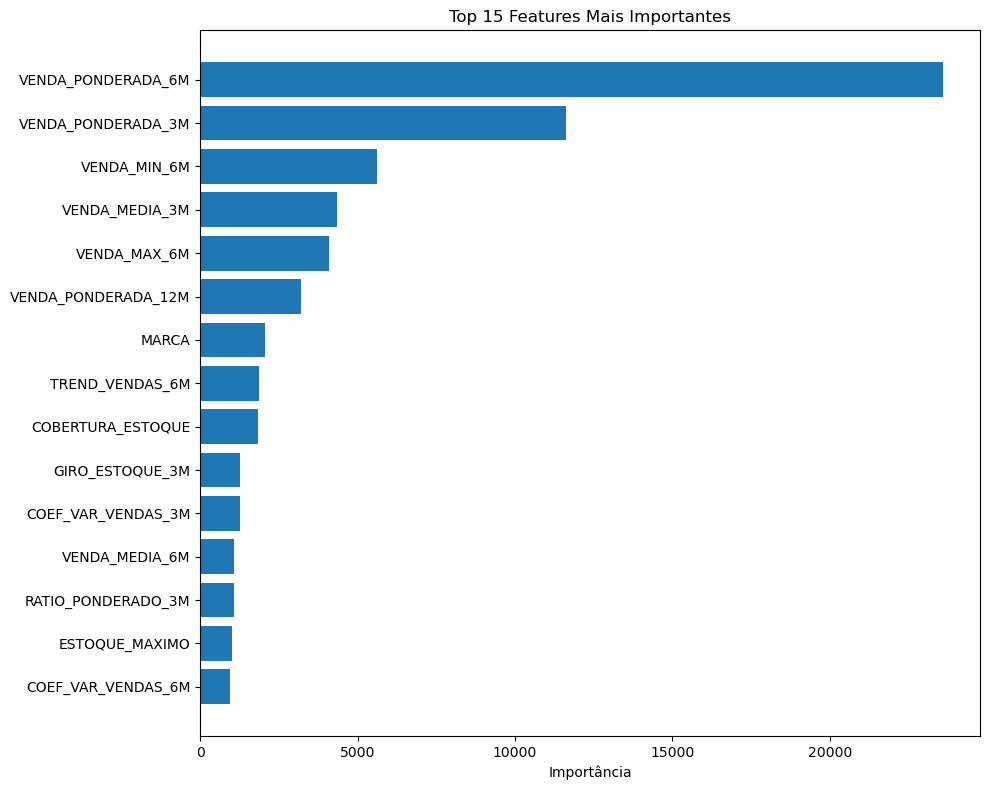


🔮 Fazendo previsões para MES_REF = 0...
🧹 Limpando dados (inf, NaN, tipos)...
✅ Dados limpos e prontos para o modelo
✅ Previsões concluídas para 6011 produtos
📈 Previsão média: 4.50
📊 Previsão máxima: 638.25

💾 Salvando resultados...

📊 AVALIAÇÃO DO MODELO
🧹 Limpando dados (inf, NaN, tipos)...
✅ Dados limpos e prontos para o modelo
MAE: 3.49
RMSE: 9.66
R²: 0.6469
MAPE: 90.61%
sMAPE: 151.16%

📈 Performance por faixa de vendas:
   0-10: MAE 3.55 (1690 amostras)
   10-50: MAE 10.86 (527 amostras)
   50-100: MAE 26.73 (77 amostras)
   100-500: MAE 52.34 (38 amostras)
✅ Pipeline completo finalizado!
📊 R² Final (Pro): 0.647, MAE: 3.49


In [65]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')

# ===== Imports essenciais =====
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
import xgboost as xgb

# =========================
# Configurações globais
# =========================
CONFIG = {
    'test_month': -1,
    'target_month': 0,
    'random_state': 42
}

# =========================
# Classe base
# =========================
class SalesForecaster:
    def __init__(self, config=None):
        self.config = config or CONFIG
        self.model = None
        self.label_encoders = {}
        self.features = []
        self.cat_cols = ['CATEGORIA PRODUTO', 'TIER', 'MARCA', 'MODELO', 'ARO', 'TAMANHO DIMENSÃO','UF']
        self.cat_cols_2 = ['CATEGORIA PRODUTO', 'MARCA']

    def prepare_features(self, df):
        """Seleciona features ENGINEERED (sem usar lags brutos)."""
        print("🎯 Selecionando features ENGINEERED...")

        exclude_cols = [
            'MES_REF', 'Venda Qtd', 'Estoque', '% Margem', 'UNIFICADOR',
            # lags brutos de venda
            'VENDA_LAG_1','VENDA_LAG_2','VENDA_LAG_3','VENDA_LAG_4','VENDA_LAG_5',
            'VENDA_LAG_6','VENDA_LAG_7','VENDA_LAG_8','VENDA_LAG_9','VENDA_LAG_10',
            'VENDA_LAG_11','VENDA_LAG_12','VENDA_LAG_13',
            # lags brutos de estoque
            'ESTOQUE_LAG_1','ESTOQUE_LAG_2','ESTOQUE_LAG_3','ESTOQUE_LAG_4',
            'ESTOQUE_LAG_5','ESTOQUE_LAG_6','ESTOQUE_LAG_7','ESTOQUE_LAG_8',
            'ESTOQUE_LAG_9','ESTOQUE_LAG_10','ESTOQUE_LAG_11','ESTOQUE_LAG_12','ESTOQUE_LAG_13',
            # lags brutos de margem
            'MARGEM_LAG_1','MARGEM_LAG_2','MARGEM_LAG_3','MARGEM_LAG_4',
            'MARGEM_LAG_5','MARGEM_LAG_6','MARGEM_LAG_7','MARGEM_LAG_8','MARGEM_LAG_9'
        ]

        engineered_features = [
            'VENDA_MEDIA_3M','VENDA_MEDIA_6M','VENDA_MEDIA_9M','VENDA_MEDIA_12M',
            'TREND_VENDAS_3M','TREND_VENDAS_6M','TREND_VENDAS_9M','TREND_VENDAS_12M',
            'STD_VENDAS_3M','STD_VENDAS_6M','COEF_VAR_VENDAS_3M','COEF_VAR_VENDAS_6M',

            'VENDA_PONDERADA_3M','VENDA_PONDERADA_6M','VENDA_PONDERADA_12M',
            'RATIO_PONDERADO_3M','RATIO_PONDERADO_6M','TREND_PONDERADA_3M',

            # ✅ NOVAS FEATURES IMPORTANTES
            'VENDA_MIN_6M','VENDA_MAX_6M','AMPLITUDE_VENDA_6M',
            'ESTOQUE_MINIMO','ESTOQUE_MAXIMO','GIRO_ESTOQUE_3M','COBERTURA_ESTOQUE'
        ]


        available_features = [f for f in engineered_features if f in df.columns]
        all_features = self.cat_cols_2 + available_features
        final_features = [c for c in all_features if c in df.columns and c not in exclude_cols]

        print(f"📋 Features ENGINEERED selecionadas: {len(final_features)}")
        ponderadas = [f for f in final_features if ('PONDERADA' in f or 'PONDERADO' in f)]
        if ponderadas:
            print(f"🔝 Features com pesos: {len(ponderadas)}")

        return final_features

    def encode_data(self, df, is_training=True):
        """LabelEncoding consistente para categorias."""
        df_encoded = df.copy()
        for col in self.cat_cols:
            if col in df_encoded.columns:
                if is_training:
                    le = LabelEncoder()
                    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
                    self.label_encoders[col] = le
                else:
                    le = self.label_encoders.get(col)
                    if le is not None:
                        mask = ~df_encoded[col].astype(str).isin(le.classes_)
                        if mask.any():
                            df_encoded.loc[mask, col] = 'DESCONHECIDO'
                        df_encoded[col] = le.transform(df_encoded[col].astype(str))
        return df_encoded

    def _clean_data(self, X):
        """Trata NaN/inf e converte tipos."""
        X_fixed = X.copy()
        print("🧹 Limpando dados (inf, NaN, tipos)...")
        for col in X_fixed.columns:
            if not pd.api.types.is_numeric_dtype(X_fixed[col]):
                X_fixed[col] = pd.to_numeric(X_fixed[col], errors='coerce')

            if np.isinf(X_fixed[col]).any():
                cnt = np.isinf(X_fixed[col]).sum()
                print(f"   ⚠️  {cnt} valores infinitos em {col} → convertendo para NaN")
                X_fixed[col] = X_fixed[col].replace([np.inf, -np.inf], np.nan)

            large_mask = X_fixed[col].abs() > 1e10
            if large_mask.any():
                print(f"   ⚠️  {large_mask.sum()} valores extremos em {col} → NaN")
                X_fixed.loc[large_mask, col] = np.nan

        for col in X_fixed.columns:
            nan_count = X_fixed[col].isna().sum()
            if nan_count > 0:
                med = X_fixed[col].median()
                X_fixed[col] = X_fixed[col].fillna(med)
                print(f"   ✅ {nan_count} NaN em {col} preenchidos com mediana {med:.2f}")

        if np.isinf(X_fixed.values).any() or np.isnan(X_fixed.values).any():
            print("❌ AINDA EXISTEM VALORES PROBLEMÁTICOS!")
        else:
            print("✅ Dados limpos e prontos para o modelo")
        return X_fixed

    def _optimize_hyperparameters(self, X_train, y_train):
        """Busca simples de hiperparâmetros (usada só se você chamar train(...))."""
        print("🔧 Iniciando otimização de hiperparâmetros...")
        X_train_fixed = self._clean_data(X_train)
        print(f"✅ Dados prontos: {X_train_fixed.shape}")

        param_grid = {
            'n_estimators': [300, 500],
            'max_depth': [4, 6],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.8, 0.9]
        }

        model = XGBRegressor(
            random_state=self.config['random_state'],
            n_jobs=-1,
            missing=np.nan
        )

        tscv = TimeSeriesSplit(n_splits=3)

        search = RandomizedSearchCV(
            model,
            param_grid,
            n_iter=4,
            scoring='neg_mean_absolute_error',
            cv=tscv,
            verbose=1,
            random_state=self.config['random_state'],
            n_jobs=1
        )

        print("🔄 Executando busca de hiperparâmetros...")
        search.fit(X_train_fixed, y_train)
        self.model = search.best_estimator_
        print(f"🎯 Melhores parâmetros: {search.best_params_}")
        print(f"🎯 Melhor score (MAE): {-search.best_score_:.2f}")

    def train(self, X_train, y_train, optimize_hyperparams=True):
        """Treina XGBRegressor (sem Pro)."""
        if optimize_hyperparams:
            self._optimize_hyperparameters(X_train, y_train)
        else:
            X_train_fixed = self._clean_data(X_train)
            self.model = XGBRegressor(
                n_estimators=500,
                learning_rate=0.1,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=self.config['random_state'],
                n_jobs=-1,
                missing=np.nan
            )
            self.model.fit(X_train_fixed, y_train)
            print("✅ Modelo treinado com parâmetros padrão")

# =========================
# Versão Pro (Booster)
# =========================
class SalesForecaster_Pro(SalesForecaster):
    def train_advanced(self, X_train, y_train):
        """Treinamento avançado compatível com XGBoost 3.1.1 usando xgb.train + DMatrix."""
        print("⚙️ Treinando modelo avançado SalesForecaster_Pro (XGBoost 3.1.1)...")

        X_train_fixed = self._clean_data(X_train)
        dtrain = xgb.DMatrix(X_train_fixed, label=y_train)

        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'mae',
            'eta': 0.05,
            'max_depth': 8,
            'subsample': 0.85,
            'colsample_bytree': 0.85,
            'tree_method': 'auto',
            'seed': self.config['random_state']
        }

        evals = [(dtrain, 'train')]
        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=2000,
            evals=evals,
            early_stopping_rounds=20,
            verbose_eval=False
        )

        self.model = booster
        print("✅ Modelo avançado treinado com sucesso!")
        print(f"🔢 Best iteration: {booster.best_iteration}")
        return self.model

# =========================
# Utilitários
# =========================
def get_base_score(model):
    """
    Retorna base_score tanto para Booster (xgb.train) quanto para XGBRegressor.
    """
    # Booster direto
    if isinstance(model, xgb.Booster):
        cfg = json.loads(model.save_config())
    else:
        # XGBRegressor → pega booster interno
        booster = model.get_booster()
        cfg = json.loads(booster.save_config())

    base_score_raw = cfg["learner"]["learner_model_param"]["base_score"]
    if isinstance(base_score_raw, str) and base_score_raw.startswith("[") and base_score_raw.endswith("]"):
        base_score_raw = base_score_raw.strip("[]")
    return float(base_score_raw)

def feature_importance_analysis(model, features, X_train):
    """
    Importância de features para Booster OU XGBRegressor.
    - Booster: usa get_score(importance_type='gain') com nomes reais das colunas do DataFrame (via DMatrix).
    - XGBRegressor: usa .feature_importances_.
    """
    print("\n🔍 ANALISANDO IMPORTÂNCIA DAS FEATURES")

    if isinstance(model, xgb.Booster):
        # Para pegar nomes consistentes, garanta que o DMatrix foi criado do DataFrame com nomes.
        X_train_clean = forecaster._clean_data(X_train)
        dtrain = xgb.DMatrix(X_train_clean)  # só para garantir mapeamento de nomes
        # get_score já carrega pelas features do booster treinado
        score_dict = model.get_score(importance_type='gain')
        # Constrói DataFrame garantindo todas as features (ausentes → 0)
        imp_series = pd.Series({f: score_dict.get(f, 0.0) for f in score_dict.keys()})
        importance_df = imp_series.sort_values(ascending=False).reset_index()
        importance_df.columns = ['feature', 'importance']
    else:
        importance_df = pd.DataFrame({
            'feature': features,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

    print("🏆 Top 15 features mais importantes:")
    print(importance_df.head(15))

    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(15)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importância')
    plt.title('Top 15 Features Mais Importantes')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return importance_df

def comprehensive_evaluation(model, X_test, y_test, df_test):
    """Avaliação completa (MAE, RMSE, R², MAPE, sMAPE) + dataframe de resultados."""
    print("\n📊 AVALIAÇÃO DO MODELO")
    print("="*50)

    # limpar X_test com o mesmo forecaster global
    X_test_clean = forecaster._clean_data(X_test)

    # predição para Booster vs Regressor
    if isinstance(model, xgb.Booster):
        y_pred = model.predict(xgb.DMatrix(X_test_clean))
    else:
        y_pred = model.predict(X_test_clean)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    epsilon = 1e-6
    mask = y_test > epsilon
    if mask.sum() > 0:
        mape = float(np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100)
    else:
        mape = 0.0

    smape = float(100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred) + epsilon)))

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"sMAPE: {smape:.2f}%")

    # detalhamento por faixa
    df_result = df_test.copy()
    df_result['VENDA_PREVISTA'] = y_pred
    df_result['ERRO_ABSOLUTO'] = np.abs(df_result['Venda Qtd'] - df_result['VENDA_PREVISTA'])

    base_score = get_base_score(model)
    df_result['PREVISAO_CONFIAVEL'] = np.where(
        np.abs(df_result['VENDA_PREVISTA'] - base_score) < 1.5, 'NAO', 'SIM'
    )

    bins = [0, 10, 50, 100, 500, np.inf]
    labels = ['0-10', '10-50', '50-100', '100-500', '500+']
    df_result['FAIXA_VENDA'] = pd.cut(df_result['Venda Qtd'], bins=bins, labels=labels)

    print(f"\n📈 Performance por faixa de vendas:")
    for faixa in labels:
        mask_f = df_result['FAIXA_VENDA'] == faixa
        if mask_f.sum() > 0:
            mae_faixa = df_result.loc[mask_f, 'ERRO_ABSOLUTO'].mean()
            print(f"   {faixa}: MAE {mae_faixa:.2f} ({int(mask_f.sum())} amostras)")

    metrics = {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape, 'smape': smape}
    return df_result, metrics

def make_future_predictions(forecaster, df_final, features, target_month=0):
    """Prevê MES_REF = target_month + flag de confiabilidade."""
    print(f"\n🔮 Fazendo previsões para MES_REF = {target_month}...")
    df_future = df_final[df_final['MES_REF'] == target_month].copy()
    if len(df_future) == 0:
        print(f"❌ Nenhum dado encontrado para MES_REF = {target_month}")
        return None

    df_future_enc = forecaster.encode_data(df_future, is_training=False)
    available_features = [f for f in features if f in df_future_enc.columns]
    X_future = forecaster._clean_data(df_future_enc[available_features])

    if isinstance(forecaster.model, xgb.Booster):
        df_future['VENDA_PREVISTA'] = forecaster.model.predict(xgb.DMatrix(X_future))
    else:
        df_future['VENDA_PREVISTA'] = forecaster.model.predict(X_future)

    base_score = get_base_score(forecaster.model)
    df_future['PREVISAO_CONFIAVEL'] = np.where(
        np.abs(df_future['VENDA_PREVISTA'] - base_score) < 1.5, 'NAO', 'SIM'
    )

    df_future = df_future.sort_values(['PREVISAO_CONFIAVEL', 'VENDA_PREVISTA'], ascending=[True, False])

    print(f"✅ Previsões concluídas para {len(df_future)} produtos")
    print(f"📈 Previsão média: {df_future['VENDA_PREVISTA'].mean():.2f}")
    print(f"📊 Previsão máxima: {df_future['VENDA_PREVISTA'].max():.2f}")
    return df_future

def temporal_train_test_split(df, test_month=-1):
    """Split temporal: treino < test_month, teste == test_month."""
    df_train = df[df['MES_REF'] < test_month].copy()
    df_test  = df[df['MES_REF'] == test_month].copy()
    print(f"✅ Split temporal: Treino (MES_REF < {test_month}): {len(df_train)}")
    print(f"✅ Split temporal: Teste  (MES_REF = {test_month}): {len(df_test)}")
    return df_train, df_test

# =========================
# Pipeline principal
# =========================
def run_forecast_model():
    print("🚀 INICIANDO PIPELINE DE PREVISÃO")
    print("="*50)
    global forecaster

    try:
        print("\n📁 Carregando dataset com features...")
        df_final = pd.read_excel('dataset_completo_com_features_CORRIGIDO.xlsx')
        print(f"📊 Dataset carregado: {df_final.shape}")

        df_train, df_test = temporal_train_test_split(df_final, test_month=-1)

        # === MODELO PRO (principal) ===
        forecaster = SalesForecaster_Pro()
        features = forecaster.prepare_features(df_train)

        print(f"🎯 Total de features selecionadas: {len(features)}")

        df_train_enc = forecaster.encode_data(df_train, is_training=True)
        df_test_enc  = forecaster.encode_data(df_test,  is_training=False)

        available_features = [f for f in features if f in df_train_enc.columns and f in df_test_enc.columns]
        print(f"✅ Features disponíveis: {len(available_features)}")

        X_train = df_train_enc[available_features]
        y_train = df_train_enc['Venda Qtd']
        X_test  = df_test_enc[available_features]
        y_test  = df_test_enc['Venda Qtd']

        print(f"🧩 Dados preparados: X_train {X_train.shape}, X_test {X_test.shape}")

        print("\n🤖 Treinando modelo (Pro)...")
        forecaster.train_advanced(X_train, y_train)

        #==============================
        # 🔥 COMPARAÇÃO: MODELO NORMAL
        #==============================
        print("\n🔗 Iniciando comparação com MODELO NORMAL...")

        forecaster_normal = SalesForecaster()
        forecaster_normal.features = available_features.copy()

        df_train_enc_n = forecaster_normal.encode_data(df_train, is_training=True)
        df_test_enc_n  = forecaster_normal.encode_data(df_test, is_training=False)

        X_train_n = df_train_enc_n[available_features]
        y_train_n = df_train_enc_n['Venda Qtd']
        X_test_n  = df_test_enc_n[available_features]
        y_test_n  = df_test_enc_n['Venda Qtd']

        print("\n🤖 Treinando MODELO NORMAL...")
        forecaster_normal.train(X_train_n, y_train_n, optimize_hyperparams=False)

        print("\n📊 Avaliando MODELO NORMAL...")
        results_normal, metrics_normal = comprehensive_evaluation(
            forecaster_normal.model, X_test_n, y_test_n, df_test
        )

        print("\n📊 Avaliando MODELO PRO...")
        results_pro, metrics_pro = comprehensive_evaluation(
            forecaster.model, X_test, y_test, df_test
        )

        print("\n======================================================")
        print("               🔥 COMPARAÇÃO FINAL")
        print("======================================================")
        print(f"MODELO NORMAL → MAE: {metrics_normal['mae']:.2f}, R²: {metrics_normal['r2']:.4f}, MAPE: {metrics_normal['mape']:.2f}%")
        print(f"MODELO PRO     → MAE: {metrics_pro['mae']:.2f}, R²: {metrics_pro['r2']:.4f}, MAPE: {metrics_pro['mape']:.2f}%")
        print("======================================================")

        results_normal.to_excel("resultados_normal.xlsx", index=False)
        results_pro.to_excel("resultados_pro.xlsx", index=False)

        #==============================
        # Continuação do pipeline Pro
        #==============================
        importance_df = feature_importance_analysis(forecaster.model, available_features, X_train)
        df_pred_0 = make_future_predictions(forecaster, df_final, available_features, target_month=0)

        print("\n💾 Salvando resultados...")
        df_results, metrics = comprehensive_evaluation(forecaster.model, X_test, y_test, df_test)
        df_results.to_excel('resultados_previsao_mes_-1.xlsx', index=False)

        if df_pred_0 is not None:
            df_pred_0.to_excel('previsoes_mes_0.xlsx', index=False)

        importance_df.to_excel('importancia_features_final.xlsx', index=False)

        print("✅ Pipeline completo finalizado!")
        print(f"📊 R² Final (Pro): {metrics['r2']:.3f}, MAE: {metrics['mae']:.2f}")

        return df_results, df_pred_0, metrics, importance_df, forecaster, features, df_final

    except Exception as e:
        print(f"❌ Erro no pipeline: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None, None, None


if __name__ == "__main__":
    resultados, previsoes, metricas, importancia, forecaster, features, df_final = run_forecast_model()


In [38]:
#### TESTANDO DOIS MODELOS ####
import xgboost as xgb
print("Versão XGBoost:", xgb.__version__)


Versão XGBoost: 3.1.1


In [25]:
#pip install shap


In [96]:
# --- PATCH 1: fix_base_score genérico (serve Booster e XGBRegressor) ---
import json
import xgboost as xgb

def fix_base_score(model):
    """
    Corrige base_score do XGBoost quando está no formato "[6.79E0]",
    converte para "6.79E0" e recarrega o booster corretamente.
    """
    if hasattr(model, "get_booster"):
        booster = model.get_booster()
    else:
        booster = model  # já é um xgb.Booster

    cfg = json.loads(booster.save_config())
    raw = cfg["learner"]["learner_model_param"]["base_score"]

    if raw.startswith("[") and raw.endswith("]"):
        cleaned = raw.strip("[]")
        cfg["learner"]["learner_model_param"]["base_score"] = cleaned
        booster.load_config(json.dumps(cfg))
        print(f"✅ base_score corrigido: {raw} → {cleaned}")
    else:
        print("ℹ️ base_score já estava correto.")

    return model   # retorna o modelo intacto (apenas booster corrigido)


# --- PATCH 2: SHAP para 1 linha ---
def explain_single_prediction(forecaster, df_final, features, unificador, uf, mes_ref):
    import shap
    import numpy as np
    import pandas as pd
    import xgboost as xgb

    print("\n🔍 Buscando a linha alvo...")

    row = df_final[
        (df_final['UNIFICADOR'] == unificador) &
        (df_final['UF'] == uf) &
        (df_final['MES_REF'] == mes_ref)
    ].copy()

    if row.empty:
        print("❌ Nenhum registro encontrado.")
        return None

    # Encoding e limpeza
    row_enc = forecaster.encode_data(row, is_training=False)
    use_feats = [f for f in features if f in row_enc.columns]
    X_row = forecaster._clean_data(row_enc[use_feats]).iloc[[0]]

    # --- Corrigir base_score corretamente no booster ---
    if hasattr(forecaster.model, "get_booster"):
        booster = forecaster.model.get_booster()
    else:
        booster = forecaster.model

    booster = fix_base_score_for_booster(booster)

    # ----- PREVISÃO (sempre feita via Booster para consistência) -----
    y_pred = booster.predict(xgb.DMatrix(X_row))[0]

    print(f"\n📈 Previsão do modelo para {unificador}-{uf} (MES_REF {mes_ref}): {y_pred:.2f}")

    # ----- SHAP -----
    print("\n🔍 Calculando contribuições SHAP...")

    explainer = shap.TreeExplainer(booster)
    X_np = X_row.to_numpy(dtype=float)
    shap_values = explainer.shap_values(X_np)
    expected_value = explainer.expected_value

    vals = shap_values[0]

    shap_df = pd.DataFrame({
        'Feature': X_row.columns,
        'Valor': X_row.iloc[0].values,
        'Impacto SHAP': vals
    }).assign(Impacto_Abs=lambda d: d['Impacto SHAP'].abs()) \
     .sort_values('Impacto_Abs', ascending=False)

    print("\n🏆 Top 12 contribuições relevantes:")
    print(shap_df.head(12))

    try:
        shap.plots.waterfall(
            shap.Explanation(
                values=vals,
                base_values=float(expected_value if np.ndim(expected_value)==0 else expected_value[0]),
                data=X_np[0],
                feature_names=list(X_row.columns)
            ),
            max_display=12
        )
    except Exception as e:
        print(f"ℹ️ Waterfall não exibido: {e}")

    return shap_df[['Feature', 'Valor', 'Impacto SHAP']]



In [97]:
df_pred_0 = pd.read_excel('previsoes_mes_0.xlsx')

shap_result = explain_single_prediction(
    forecaster,
    df_final,     # use o dataset completo, não o df_pred_0
    features,
    unificador='MR003876',
    uf='RS',
    mes_ref=0
)




🔍 Buscando a linha alvo...
🧹 Limpando dados (inf, NaN, tipos)...
✅ Dados limpos e prontos para o modelo
✅ base_score corrigido: [6.795195E0] → 6.795195E0

📈 Previsão do modelo para MR003876-RS (MES_REF 0): 197.17

🔍 Calculando contribuições SHAP...


ValueError: could not convert string to float: '[6.795195E0]'

In [52]:
forecaster.model = fix_base_score(forecaster.model)


AttributeError: 'Booster' object has no attribute 'get_booster'

In [53]:
print(forecaster.model.get_booster().save_config())


AttributeError: 'Booster' object has no attribute 'get_booster'

In [54]:
import shap

def explain_single_prediction(forecaster, df_final, features, unificador, uf, mes_ref):

    row = df_final[
        (df_final['UNIFICADOR'] == unificador) &
        (df_final['UF'] == uf) &
        (df_final['MES_REF'] == mes_ref)
    ].copy()

    if row.empty:
        print("❌ Nenhum registro encontrado.")
        return

    row_encoded = forecaster.encode_data(row, is_training=False)
    X_row = row_encoded[features].copy()

    # Garantir numérico
    X_row = X_row.apply(pd.to_numeric, errors='coerce').fillna(X_row.median())

    # Previsão
    y_pred = forecaster.model.predict(X_row)[0]
    print(f"📈 Previsão do modelo: {y_pred:.2f}")

    # ✅ SHAP com "model.predict" ao invés de booster → zero erro
    explainer = shap.Explainer(forecaster.model.predict, X_row)

    shap_values = explainer(X_row)

    # Top contribuições
    shap_df = pd.DataFrame({
        'Feature': X_row.columns,
        'Valor': X_row.values.flatten(),
        'Impacto SHAP': shap_values.values.flatten()
    })

    # Ordenar pelo impacto (em valor absoluto)
    shap_df['Impacto_Abs'] = shap_df['Impacto SHAP'].abs()
    shap_df = shap_df.sort_values('Impacto_Abs', ascending=False)

    # Remover contribuições irrelevantes (0)
    shap_df_filtered = shap_df[shap_df['Impacto_Abs'] > 1e-6].copy()

    print("\n🏆 Principais contribuições relevantes (Impacto ≠ 0):")
    print(shap_df_filtered[['Feature', 'Valor', 'Impacto SHAP']].head(12))

    # Para visualização no retorno
    return shap_df_filtered[['Feature', 'Valor', 'Impacto SHAP']]


    shap.plots.waterfall(shap_values[0], max_display=12)

    return shap_df


In [55]:
df_pred_0 = pd.read_excel('previsoes_mes_0.xlsx')




shap_result = explain_single_prediction(
    forecaster,
    df_pred_0,
    features,
    unificador='MR003876',
    uf='RS',
    mes_ref=0
)




TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

In [ ]:
forecaster.model.get_booster().attr("base_score")


In [13]:
#### PREVISÕES PARA MESES FUTUROS +1, +2, +3 - ABORDAGEM CORRETA COM LAGS DINÂMICOS ####


In [66]:
run_forecast_model
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import re
# ---------------------------
# Utilitários de detecção de lags e operações seguras
# ---------------------------
def available_lags(df, prefix):
    """
    Retorna a lista ordenada de índices de lag disponíveis para um prefixo.
    Ex.: prefix='MARGEM' -> [1,2,...,9] se existirem colunas MARGEM_LAG_1..9
    """
    pat = re.compile(rf'^{prefix}_LAG_(\d+)$')
    idx = []
    for c in df.columns:
        m = pat.match(c)
        if m:
            idx.append(int(m.group(1)))
    return sorted(set(idx))

def shift_lags_row(df, prefix, avail, new_lag1_value):
    """
    Faz o shift "in place" nas colunas {prefix}_LAG_i conforme avail.
    Ex.: para i=9..2: LAG_i <- LAG_{i-1}; LAG_1 <- new_lag1_value
    """
    if not avail:
        return df

    # Shift dos lags (do maior para o menor)
    for i in sorted(avail, reverse=True):
        if i == 1:
            continue
        prev_lag = i - 1
        if prev_lag in avail:
            df[f'{prefix}_LAG_{i}'] = df[f'{prefix}_LAG_{prev_lag}']
        else:
            # Se não existe lag anterior, preenche com NaN
            df[f'{prefix}_LAG_{i}'] = np.nan

    # Atualiza o lag 1 com o novo valor
    if 1 in avail:
        df[f'{prefix}_LAG_1'] = new_lag1_value

    return df

def mean_over(df, prefix, k, avail):
    """Calcula média sobre k lags disponíveis"""
    cols = [f'{prefix}_LAG_{i}' for i in range(1, k+1) if i in avail]
    if not cols:
        return pd.Series(0.0, index=df.index)
    return df[cols].mean(axis=1)

def std_over(df, prefix, k, avail):
    """Calcula desvio padrão sobre k lags disponíveis"""
    cols = [f'{prefix}_LAG_{i}' for i in range(1, k+1) if i in avail]
    if not cols:
        return pd.Series(0.0, index=df.index)
    return df[cols].std(axis=1)

def trend_over(df, prefix, k, avail, min_points=2):
    """Calcula tendência linear sobre k lags disponíveis"""
    cols = [f'{prefix}_LAG_{i}' for i in range(1, k+1) if i in avail]
    if len(cols) < min_points:
        return pd.Series(0.0, index=df.index)

    def calc_trend(row):
        values = [row[col] for col in cols if not pd.isna(row[col])]
        if len(values) < min_points:
            return 0.0
        x = np.arange(len(values))
        return np.polyfit(x, values, 1)[0]

    return df.apply(calc_trend, axis=1)

# ---------------------------
# Recalcula features APENAS na linha/df simulado do mês futuro
# ---------------------------
def recompute_features_row(df):
    """Recalcula TODAS as features baseadas nos novos lags"""
    venda_avail   = available_lags(df, 'VENDA')
    estoque_avail = available_lags(df, 'ESTOQUE')
    margem_avail  = available_lags(df, 'MARGEM')

    print(f"    📊 Recalculando features - Venda lags: {venda_avail}, Estoque lags: {estoque_avail}")

    # Vendas: médias e tendências
    df['VENDA_MEDIA_3M']  = mean_over(df, 'VENDA', 3, venda_avail)
    df['VENDA_MEDIA_6M']  = mean_over(df, 'VENDA', 6, venda_avail)
    df['VENDA_MEDIA_9M']  = mean_over(df, 'VENDA', 9, venda_avail)
    df['VENDA_MEDIA_12M'] = mean_over(df, 'VENDA', 12, venda_avail)

    df['TREND_VENDAS_3M']  = trend_over(df, 'VENDA', 3, venda_avail, min_points=2)
    df['TREND_VENDAS_6M']  = trend_over(df, 'VENDA', 6, venda_avail, min_points=3)
    df['TREND_VENDAS_9M']  = trend_over(df, 'VENDA', 9, venda_avail, min_points=5)
    df['TREND_VENDAS_12M'] = trend_over(df, 'VENDA', 12, venda_avail, min_points=7)

    # Volatilidade
    eps = 1e-3
    df['STD_VENDAS_3M'] = std_over(df, 'VENDA', 3, venda_avail)
    df['STD_VENDAS_6M'] = std_over(df, 'VENDA', 6, venda_avail)
    df['COEF_VAR_VENDAS_3M'] = df['STD_VENDAS_3M'] / np.maximum(df['VENDA_MEDIA_3M'], eps)
    df['COEF_VAR_VENDAS_6M'] = df['STD_VENDAS_6M'] / np.maximum(df['VENDA_MEDIA_6M'], eps)

    # Features ponderadas (usando pesos temporais)
    if len(venda_avail) >= 3:
        lags_3m = [f'VENDA_LAG_{i}' for i in sorted(venda_avail)[:3]]
        weights_3m = [0.5, 0.3, 0.2]  # Mais peso no mais recente
        df['VENDA_PONDERADA_3M'] = df[lags_3m].apply(
            lambda row: np.average(row, weights=weights_3m[:len(row)]), axis=1
        )
    else:
        df['VENDA_PONDERADA_3M'] = df['VENDA_MEDIA_3M']

    if len(venda_avail) >= 6:
        lags_6m = [f'VENDA_LAG_{i}' for i in sorted(venda_avail)[:6]]
        weights_6m = [0.35, 0.25, 0.15, 0.10, 0.08, 0.07]
        df['VENDA_PONDERADA_6M'] = df[lags_6m].apply(
            lambda row: np.average(row, weights=weights_6m[:len(row)]), axis=1
        )
    else:
        df['VENDA_PONDERADA_6M'] = df['VENDA_MEDIA_6M']

    # Ratios e tendências ponderadas
    df['RATIO_PONDERADO_3M'] = df['VENDA_PONDERADA_3M'] / (df['VENDA_MEDIA_3M'] + eps)
    df['RATIO_PONDERADO_6M'] = df['VENDA_PONDERADA_6M'] / (df['VENDA_MEDIA_6M'] + eps)
    df['TREND_PONDERADA_3M'] = (df['VENDA_PONDERADA_3M'] - df['VENDA_MEDIA_3M']) / (df['VENDA_MEDIA_3M'] + eps)

    # Estoque
    df['ESTOQUE_MEDIA_3M'] = mean_over(df, 'ESTOQUE', 3, estoque_avail)
    df['ESTOQUE_MEDIA_6M'] = mean_over(df, 'ESTOQUE', 6, estoque_avail)

    # Cobertura e giro
    estoque_lag1 = f'ESTOQUE_LAG_{min(estoque_avail)}' if estoque_avail else 'ESTOQUE_LAG_1'
    df['COBERTURA_ESTOQUE'] = df[estoque_lag1] / (df['VENDA_MEDIA_3M'] + 1)
    df['GIRO_ESTOQUE_3M'] = df['VENDA_MEDIA_3M'] / (df['ESTOQUE_MEDIA_3M'] + 1)

    # Trend estoque
    df['TREND_ESTOQUE_3M'] = trend_over(df, 'ESTOQUE', 3, estoque_avail, min_points=2)

    # Estatísticas estoque
    if estoque_avail:
        cols_all_est = [f'ESTOQUE_LAG_{i}' for i in estoque_avail]
        df['ESTOQUE_MEDIA_GERAL'] = df[cols_all_est].mean(axis=1)
        df['STD_ESTOQUE_3M'] = std_over(df, 'ESTOQUE', 3, estoque_avail)
        df['ESTOQUE_MINIMO'] = df[cols_all_est].min(axis=1)
        df['ESTOQUE_MAXIMO'] = df[cols_all_est].max(axis=1)
        df['ESTOQUE_TENDENCIA'] = trend_over(df, 'ESTOQUE', len(estoque_avail), estoque_avail, min_points=3)
    else:
        df['ESTOQUE_MEDIA_GERAL'] = 0.0
        df['STD_ESTOQUE_3M'] = 0.0
        df['ESTOQUE_MINIMO'] = 0.0
        df['ESTOQUE_MAXIMO'] = 0.0
        df['ESTOQUE_TENDENCIA'] = 0.0

    # Margem
    df['MARGEM_MEDIA_3M'] = mean_over(df, 'MARGEM', 3, margem_avail)
    df['MARGEM_MEDIA_6M'] = mean_over(df, 'MARGEM', 6, margem_avail)
    df['TREND_MARGEM_3M'] = trend_over(df, 'MARGEM', 3, margem_avail, min_points=2)
    df['TREND_MARGEM_6M'] = trend_over(df, 'MARGEM', 6, margem_avail, min_points=3)

    # Scores compostos
    df['SAUDE_PRODUTO'] = (
        df['TREND_VENDAS_3M'].clip(-100, 100) * 0.4 +
        df['COEF_VAR_VENDAS_3M'].clip(0, 10) * 0.3 +
        df['TREND_MARGEM_3M'].clip(-1, 1) * 0.3
    )

    df['RISCO_RUPTURA_SCORE'] = (
        (df['COBERTURA_ESTOQUE'] < 1).astype(int) * 0.6 +
        (df['TREND_VENDAS_3M'] > 0).astype(int) * 0.4
    )

    df['PRESSAO_RUPTURA'] = df['VENDA_MEDIA_3M'] / (df[estoque_lag1] + 1)

    return df

def safe_encode_data(forecaster, df, is_training=False):
    """Encoding seguro que lida com valores não vistos"""
    df_encoded = df.copy()

    for col in forecaster.cat_cols:
        if col in df_encoded.columns:
            le = forecaster.label_encoders.get(col)
            if le is not None:
                # Converter para string e tratar valores não vistos
                df_encoded[col] = df_encoded[col].astype(str)

                # Identificar valores não vistos
                unseen_mask = ~df_encoded[col].isin(le.classes_)

                if unseen_mask.any():
                    print(f"   ⚠️  Encontrados {unseen_mask.sum()} valores não vistos em {col}")
                    # Mapear valores não vistos para uma categoria conhecida
                    if len(le.classes_) > 0:
                        most_frequent = le.classes_[0]
                        df_encoded.loc[unseen_mask, col] = most_frequent
                        print(f"   ✅ Valores não vistos mapeados para: {most_frequent}")

                # Aplicar encoding
                df_encoded[col] = le.transform(df_encoded[col])

    return df_encoded

# ---------------------------
# Forecast recursivo com evolução temporal CORRETA
# ---------------------------
def forecast_future_months_correct(df_final, forecaster, features, target_months=[1, 2, 3]):
    """Faz previsões futuras com evolução temporal correta dos lags"""
    print(f"🔮 INICIANDO PREVISÕES COM EVOLUÇÃO TEMPORAL: {target_months}")
    print("="*60)

    # Detectar lags disponíveis
    venda_avail = available_lags(df_final, 'VENDA')
    estoque_avail = available_lags(df_final, 'ESTOQUE')
    margem_avail = available_lags(df_final, 'MARGEM')

    print(f"📊 Lags detectados - Venda: {venda_avail}, Estoque: {estoque_avail}, Margem: {margem_avail}")

    all_predictions = []

    for i, month in enumerate(sorted(target_months)):
        print(f"\n📅 PROCESSANDO MÊS {month}...")

        if i == 0:
            # Agora usamos a combinação UNIFICADOR + UF
            base_data = df_final[df_final['MES_REF'] == 0].copy()
            if len(base_data) == 0:
                base_data = df_final[df_final['MES_REF'] == -1].copy()

            # Garantir que não existem duplicatas inesperadas
            base_data = base_data.drop_duplicates(subset=['UNIFICADOR', 'UF'])

        else:
            # Meses subsequentes: usar previsão do mês anterior
            base_data = previous_predictions.copy()

        # Criar dados para este mês futuro
        future_data = base_data.copy()
        # Ordena para evitar embaralhamento nas previsões
        future_data = future_data.sort_values(['UNIFICADOR','UF']).reset_index(drop=True)
        future_data['MES_REF'] = month

        print(f"   🔄 Evoluindo lags temporais...")

        # Shift dos lags de VENDA
        if i == 0:
            # Primeira iteração: usar venda real como novo LAG_1
            new_venda_lag1 = future_data['Venda Qtd']
        else:
            # Iterações seguintes: usar previsão anterior como novo LAG_1
            new_venda_lag1 = future_data['VENDA_PREVISTA']

        future_data = shift_lags_row(future_data, 'VENDA', venda_avail, new_venda_lag1)

        # Shift dos lags de ESTOQUE (carry-forward)
        if estoque_avail:
            estoque_lag1_source = f'ESTOQUE_LAG_{min(estoque_avail)}'
            future_data = shift_lags_row(future_data, 'ESTOQUE', estoque_avail, future_data[estoque_lag1_source])

        # Shift dos lags de MARGEM (carry-forward)
        if margem_avail:
            margem_lag1_source = f'MARGEM_LAG_{min(margem_avail)}'
            future_data = shift_lags_row(future_data, 'MARGEM', margem_avail, future_data[margem_lag1_source])

        # RECALCULAR TODAS AS FEATURES baseadas nos novos lags
        print("   📊 Recalculando features com novos lags...")
        future_data = recompute_features_row(future_data)

        # Encoding
        future_enc = safe_encode_data(forecaster, future_data, is_training=False)

        # Garantir que todas as features existem
        available_features = [f for f in features if f in future_enc.columns]
        X_future = forecaster._clean_data(future_enc[available_features])

        # Fazer previsão
        #predictions = forecaster.model.predict(X_future)
        predictions = forecaster.model.predict(xgb.DMatrix(X_future))
        future_data['VENDA_PREVISTA'] = predictions
        future_data['MES_PREVISAO'] = month
        future_data['DATA_PREVISAO'] = pd.Timestamp.now().strftime('%Y-%m-%d')

        all_predictions.append(future_data)

        # Guardar para próxima iteração
        previous_predictions = future_data.copy()

        print(f"   ✅ Mês {month}: Previsão média = {predictions.mean():.2f}")

        # Mostrar evolução das features principais
        if i > 0:
            prev_avg = all_predictions[i-1]['VENDA_PREVISTA'].mean()
            curr_avg = predictions.mean()
            change_pct = ((curr_avg - prev_avg) / prev_avg * 100) if prev_avg != 0 else 0
            print(f"   📈 Variação vs mês {month-1}: {change_pct:+.1f}%")

    if all_predictions:
        df_all_predictions = pd.concat(all_predictions, ignore_index=True)

        # Ordenar por mês e previsão
        df_all_predictions = df_all_predictions.sort_values(['MES_PREVISAO','UNIFICADOR','UF'])


        print(f"\n🎯 PREVISÕES COM EVOLUÇÃO TEMPORAL CONCLUÍDAS:")
        print(f"   📋 Total de previsões: {len(df_all_predictions)}")

        return df_all_predictions
    else:
        print("❌ Nenhuma previsão foi gerada")
        return None

def run_correct_future_forecasts():
    """Pipeline principal com abordagem correta"""
    print("🚀 INICIANDO PREVISÕES FUTURAS - ABORDAGEM CORRETA")
    print("="*60)

    try:
        # 1. Carregar dataset
        print("\n📁 Carregando dataset com features...")
        df_final = pd.read_excel('dataset_completo_com_features_CORRIGIDO.xlsx')
        print(f"📊 Dataset carregado: {df_final.shape}")

        # 2. Verificar modelo
        print("\n🤖 Verificando modelo treinado...")
        if 'forecaster' not in globals() or forecaster.model is None:
            print("❌ Modelo não encontrado. Execute o pipeline de treinamento primeiro.")
            return None
        print("✅ Modelo carregado")

        # 3. Preparar features
        features = forecaster.prepare_features(df_final)
        print(f"🎯 Features selecionadas: {len(features)}")

        
        # ✅ NOVO PASSO: Atualizar MES_REF = 0 com VENDA_PREVISTA_0
        if os.path.exists("previsoes_mes_0.xlsx"):
            print("\n🔄 Atualizando MES_REF = 0 com VENDA_PREVISTA_0...")
            df_pred0 = pd.read_excel("previsoes_mes_0.xlsx")

            df_pred0 = df_pred0.groupby(['UNIFICADOR','UF'], as_index=False)['VENDA_PREVISTA'].mean()

            mask = (df_final['MES_REF'] == 0)
            df_merge = df_final.loc[mask, ['UNIFICADOR','UF']].merge(df_pred0, on=['UNIFICADOR','UF'], how='left')

            df_final['VENDA_PREVISTA_0'] = np.nan
            df_final.loc[mask,'VENDA_PREVISTA_0'] = df_merge['VENDA_PREVISTA'].values

            df_final.loc[mask,'Venda Qtd'] = np.where(
                df_final.loc[mask,'VENDA_PREVISTA_0'].notna(),
                df_final.loc[mask,'VENDA_PREVISTA_0'],
                df_final.loc[mask,'Venda Qtd']
            )

            print("✅ MES_REF = 0 atualizado com VENDA_PREVISTA_0")
        else:
            print("⚠️ Arquivo previsoes_mes_0.xlsx não encontrado. Pulei esta etapa.")

        # 4. Fazer previsões com evolução temporal correta
        target_months = [1, 2, 3]
        df_future_predictions = forecast_future_months_correct(
            df_final, forecaster, features, target_months
        )

        if df_future_predictions is not None:
            # 5. Análise detalhada
            print("\n📊 ANÁLISE DETALHADA DAS PREVISÕES:")
            print("="*50)

            for month in sorted(df_future_predictions['MES_PREVISAO'].unique()):
                month_data = df_future_predictions[df_future_predictions['MES_PREVISAO'] == month]
                avg_pred = month_data['VENDA_PREVISTA'].mean()
                total_pred = month_data['VENDA_PREVISTA'].sum()

                print(f"\n📅 MÊS {month}:")
                print(f"   📦 Produtos: {len(month_data)}")
                print(f"   📈 Previsão média: {avg_pred:.2f}")
                print(f"   📊 Previsão total: {total_pred:,.0f}")

                # Top 3 produtos
                top_3 = month_data.nlargest(3, 'VENDA_PREVISTA')[['UNIFICADOR', 'VENDA_PREVISTA']]
                print(f"   🔝 Top 3:")
                for _, row in top_3.iterrows():
                    print(f"      {row['UNIFICADOR']}: {row['VENDA_PREVISTA']:.0f} unidades")

            # 6. Salvar resultados
            print("\n💾 Salvando previsões...")
            df_future_predictions.to_excel('previsoes_corretas_meses_1_2_3.xlsx', index=False)
            print("✅ Previsões salvas: 'previsoes_corretas_meses_1_2_3.xlsx'")

            print(f"\n🎉 PREVISÕES COM EVOLUÇÃO TEMPORAL CONCLUÍDAS!")
            return df_future_predictions
        else:
            print("❌ Falha ao gerar previsões")
            return None

    except Exception as e:
        print(f"❌ Erro: {e}")
        import traceback
        traceback.print_exc()
        return None

#Executar previsões corretas
if __name__ == "__main__":
    print("🔮 PREVISÕES FUTURAS - ABORDAGEM CORRETA +1, +2, +3")
    print("="*60)

    required_files = ['dataset_completo_com_features_CORRIGIDO.xlsx']
    missing_files = [f for f in required_files if not os.path.exists(f)]

    if missing_files:
        print("❌ Arquivos necessários não encontrados:")
        for f in missing_files:
            print(f"   - {f}")
    else:
        print("✅ Arquivos necessários encontrados")
        previsoes = run_correct_future_forecasts()

        if previsoes is not None:
            print("\n🎉 SUCESSO! Previsões com evolução temporal geradas:")
            months = sorted(previsoes['MES_PREVISAO'].unique())
            for month in months:
                month_data = previsoes[previsoes['MES_PREVISAO'] == month]
                print(f"   Mês {month}: {month_data['VENDA_PREVISTA'].mean():.2f} (média)")
        else:
            print("\n❌ Falha nas previsões")

###############################################################
# 🔁 PIPELINE INTEGRADO COMPLETO
# Treina até MES_REF = -1 → Prevê MES_REF = 0 → Usa previsão 0
# para evoluir e prever +1, +2, +3 com lags dinâmicos
###############################################################

# def pipeline_previsao_temporal_completa():
#     print("\n🚀 INICIANDO PIPELINE COMPLETO DE PREVISÃO TEMPORAL")
#     print("=" * 60)

#     # 1️⃣ Gerar o dataset com todas as features
#     print("\n📦 Etapa 1: Gerando dataset com features...")
#     df_features = export_dataset_with_features()

#     if df_features is None or df_features.empty:
#         print("❌ Falha ao gerar dataset de features.")
#         return None

#     # 2️⃣ Rodar o modelo principal (treinamento até -1 e previsão do mês 0)
#     print("\n🤖 Etapa 2: Treinando modelo e prevendo mês 0...")
#     df_results, df_pred_0, metrics, importance_df, forecaster, features, df_final = run_forecast_model()


#     if df_pred_0 is None or df_pred_0.empty:
#         print("❌ Falha ao gerar previsões do mês 0.")
#         return None

#     # 3️⃣ Atualizar o dataset base com as previsões do mês 0 (ROBUSTO)
#     print("\n🔗 Etapa 3: Atualizando dataset com previsões do mês 0...")
#     df_base = pd.read_excel('dataset_completo_com_features_CORRIGIDO.xlsx')

#     # Garantias mínimas
#     for col in ['UNIFICADOR', 'MES_REF', 'Venda Qtd']:
#         if col not in df_base.columns:
#             raise ValueError(f"Coluna obrigatória ausente em df_base: {col}")

#     if 'UNIFICADOR' not in df_pred_0.columns or 'VENDA_PREVISTA' not in df_pred_0.columns:
#         raise ValueError("df_pred_0 precisa conter as colunas 'UNIFICADOR' e 'VENDA_PREVISTA'.")

#     # Se houver duplicidade de UNIFICADOR em df_pred_0, agregue (média ou primeiro)
#     df_pred_0_u = (
#         df_pred_0[['UNIFICADOR', 'UF', 'VENDA_PREVISTA']]
#         .groupby(['UNIFICADOR','UF'], as_index=False)['VENDA_PREVISTA']
#         .mean()
#     )

#     # Cria um DF apenas com as linhas do MES_REF == 0 já alinhadas às previsões por UNIFICADOR
#     df0_merge = (
#         df_base.loc[df_base['MES_REF'] == 0, ['UNIFICADOR','UF']]
#         .merge(df_pred_0_u, on=['UNIFICADOR','UF'], how='left')
#     )

#     # Máscara de MES_REF == 0 no df_base
#     mask0 = (df_base['MES_REF'] == 0)

#     # Cria coluna de rastreio
#     if 'VENDA_PREVISTA_0' not in df_base.columns:
#         df_base['VENDA_PREVISTA_0'] = np.nan

#     # Preenche VENDA_PREVISTA_0 **alinhado** com o índice das linhas MES_REF == 0
#     df_base.loc[mask0, 'VENDA_PREVISTA_0'] = df0_merge['VENDA_PREVISTA'].values

#     # Atualiza Venda Qtd SÓ quando existir previsão
#     tem_prev = df_base.loc[mask0, 'VENDA_PREVISTA_0'].notna().sum()
#     df_base.loc[mask0, 'Venda Qtd'] = np.where(
#         df_base.loc[mask0, 'VENDA_PREVISTA_0'].notna(),
#         df_base.loc[mask0, 'VENDA_PREVISTA_0'],
#         df_base.loc[mask0, 'Venda Qtd']
#     )

#     print(f"✅ Atualização concluída: {tem_prev} linhas de MES_REF=0 receberam VENDA_PREVISTA.")
#     df_base.to_excel('dataset_com_features_com_previsao_mes0.xlsx', index=False)
#     print("💾 Salvo em: dataset_com_features_com_previsao_mes0.xlsx")


#     # 4️⃣ Rodar as previsões futuras com evolução temporal
#     print("\n🔮 Etapa 4: Gerando previsões futuras (+1, +2, +3)...")
#     df_future_predictions = forecast_future_months_correct(
#         df_base, forecaster, forecaster.prepare_features(df_base), target_months=[1, 2, 3]
#     )

#     if df_future_predictions is not None:
#         df_future_predictions.to_excel('previsoes_pipeline_completo.xlsx', index=False)
#         print("\n🎯 Pipeline completo concluído com sucesso!")
#         print("✅ Resultado salvo em 'previsoes_pipeline_completo.xlsx'")
#         return df_future_predictions
#     else:
#         print("❌ Falha ao gerar previsões futuras.")
#         return None


# # Executar o pipeline completo (opcional)
# if __name__ == "__main__":
#     print("\n🔁 EXECUTANDO PIPELINE INTEGRADO (treino + previsões futuras)...")
#     previsoes_finais = pipeline_previsao_temporal_completa()


🔮 PREVISÕES FUTURAS - ABORDAGEM CORRETA +1, +2, +3
✅ Arquivos necessários encontrados
🚀 INICIANDO PREVISÕES FUTURAS - ABORDAGEM CORRETA

📁 Carregando dataset com features...
📊 Dataset carregado: (84154, 85)

🤖 Verificando modelo treinado...
✅ Modelo carregado
🎯 Selecionando features ENGINEERED...
📋 Features ENGINEERED selecionadas: 27
🔝 Features com pesos: 6
🎯 Features selecionadas: 27

🔄 Atualizando MES_REF = 0 com VENDA_PREVISTA_0...
✅ MES_REF = 0 atualizado com VENDA_PREVISTA_0
🔮 INICIANDO PREVISÕES COM EVOLUÇÃO TEMPORAL: [1, 2, 3]
📊 Lags detectados - Venda: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], Estoque: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], Margem: [1, 2, 3, 4, 5, 6, 7, 8, 9]

📅 PROCESSANDO MÊS 1...
   🔄 Evoluindo lags temporais...
   📊 Recalculando features com novos lags...
    📊 Recalculando features - Venda lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], Estoque lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
🧹 Limpando dados (inf, NaN, tipos)...
✅ Dados limp

In [62]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


def calculate_stockout_risk_using_real_forecasts(df_pred_0, df_future):
    """
    Calcula risco de ruptura usando previsões reais de +1, +2, +3
    Corrigido para evitar divisão por zero e explosão de risco.
    """

    print("\n🚨 INICIANDO CÁLCULO DE RISCO (COM PREVISÕES REAIS +1, +2, +3)")
    print("=" * 70)

    # 1) Renomear previsões
    df_pred_0 = df_pred_0.rename(columns={'VENDA_PREVISTA': 'PREVISAO_MES_1'})

    df_f = df_future.copy()
    df_f = df_f.rename(columns={'VENDA_PREVISTA': 'PREVISAO_MES_2'})
    df_f = df_f.rename(columns={'MES_PREVISAO': 'MES_REF'})

    # Filtrar apenas meses futuros
    df_f = df_f[df_f['MES_REF'].isin([1,2,3])]

    # ✅ Consolidar previsões duplicadas (se houver)
    df_f = df_f.groupby(['UNIFICADOR','UF','MES_REF'], as_index=False)['PREVISAO_MES_2'].mean()


    # 3) Pivot para trazer previsões futuras lado a lado
    df_pivot = df_f.pivot_table(
        index=['UNIFICADOR','UF'],
        columns='MES_REF',
        values='PREVISAO_MES_2'
    ).reset_index()

    df_pivot = df_pivot.rename(columns={
        1: 'PREVISAO_MES_2',
        2: 'PREVISAO_MES_3',
        3: 'PREVISAO_MES_4'
    })

    # 4) Unir previsões
    df = df_pred_0.merge(df_pivot, on=['UNIFICADOR','UF'], how='left')

    # Garantir colunas numéricas
    for col in ['PREVISAO_MES_1','PREVISAO_MES_2','PREVISAO_MES_3','PREVISAO_MES_4','Estoque']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # ========================================================= #
    # ✅  Correção de DIAS DE COBERTURA evitando divisão por zero
    # ========================================================= #

    def safe_cobertura(estoque, prev):
        if prev <= 0:
            return 999   # cobertura "infinita"
        return round(estoque / (prev / 30), 1)

    df['ESTOQUE_INICIAL_MES_1'] = df['Estoque']
    df['DIAS_COBERTURA_MES_1'] = df.apply(lambda x: safe_cobertura(x['ESTOQUE_INICIAL_MES_1'], x['PREVISAO_MES_1']), axis=1)

    df['ESTOQUE_INICIAL_MES_2'] = (df['ESTOQUE_INICIAL_MES_1'] - df['PREVISAO_MES_1']).clip(lower=0)
    df['DIAS_COBERTURA_MES_2'] = df.apply(lambda x: safe_cobertura(x['ESTOQUE_INICIAL_MES_2'], x['PREVISAO_MES_2']), axis=1)

    df['ESTOQUE_INICIAL_MES_3'] = (df['ESTOQUE_INICIAL_MES_2'] - df['PREVISAO_MES_2']).clip(lower=0)
    df['DIAS_COBERTURA_MES_3'] = df.apply(lambda x: safe_cobertura(x['ESTOQUE_INICIAL_MES_3'], x['PREVISAO_MES_3']), axis=1)

    # =============================================== #
    # ✅ RISCO (corrigido para não explodir valores)
    # =============================================== #
    def calc_risco(dias):
        if dias >= 60:
            return 0
        elif dias <= 7:
            return 90 + (10 * (7 - dias) / 7)
        elif dias <= 15:
            return 50 + (40 * (15 - dias) / 8)
        elif dias <= 30:
            return 10 + (40 * (30 - dias) / 15)
        return 0

    for mes in [1, 2, 3]:
        df[f'RISCO_RUPTURA_MES_{mes}'] = df[f'DIAS_COBERTURA_MES_{mes}'].apply(calc_risco).round(1)

    # ================================================= #
    # ✅ NECESSIDADE
    # ================================================= #
    for mes in [1, 2, 3]:
        df[f'NECESSIDADE_ESTOQUE_MES_{mes}'] = (df[f'PREVISAO_MES_{mes}'] * 1.5 - df['Estoque']).clip(lower=0).round(0)

    # ================================================= #
    # ✅ Consolidação
    # ================================================= #
    df['RISCO_RUPTURA_MAXIMO'] = df[[f'RISCO_RUPTURA_MES_{i}' for i in [1,2,3]]].max(axis=1)
    df['NECESSIDADE_TOTAL'] = df[[f'NECESSIDADE_ESTOQUE_MES_{i}' for i in [1,2,3]]].sum(axis=1)

    # Categorias de risco
    condicoes = [
        df['RISCO_RUPTURA_MAXIMO'] >= 80,
        df['RISCO_RUPTURA_MAXIMO'] >= 50,
        df['RISCO_RUPTURA_MAXIMO'] >= 20,
        df['RISCO_RUPTURA_MAXIMO'] > 0
    ]
    escolhas = ['CRÍTICO','ALTO','MODERADO','BAIXO']
    df['CATEGORIA_RISCO'] = np.select(condicoes, escolhas, default='SEM RISCO')

    return df



###############################################################
# EXECUÇÃO + VISÕES
###############################################################

def run_stock_risk_analysis():

    df_pred_0 = pd.read_excel("previsoes_mes_0.xlsx")
    df_future = pd.read_excel("previsoes_pipeline_completo.xlsx")

    df_risk = calculate_stockout_risk_using_real_forecasts(df_pred_0, df_future)

    df_risk.to_excel("analise_ruptura_com_previsoes_reais.xlsx", index=False)
    print("💾 Resultado salvo: analise_ruptura_com_previsoes_reais.xlsx")

    # ======= VISÕES ADICIONAIS =======
    print("\n📊 Gerando visões complementares...")

    # Top 50
    df_risk.sort_values(['RISCO_RUPTURA_MAXIMO','NECESSIDADE_TOTAL'], ascending=[False,False])\
        .head(50).to_excel("top50_risco.xlsx", index=False)

    # UF
    df_risk.groupby('UF').agg(
        SKUs=('UNIFICADOR','nunique'),
        Estoque_Total=('Estoque','sum'),
        Necessidade_Total=('NECESSIDADE_TOTAL','sum'),
        Risco_Medio=('RISCO_RUPTURA_MAXIMO','mean')
    ).reset_index().to_excel("visao_uf.xlsx", index=False)

    # Marca
    if 'MARCA' in df_risk.columns:
        df_risk.groupby('MARCA').agg(
            SKUs=('UNIFICADOR','nunique'),
            Necessidade_Total=('NECESSIDADE_TOTAL','sum'),
            Risco_Medio=('RISCO_RUPTURA_MAXIMO','mean')
        ).reset_index().to_excel("visao_marca.xlsx", index=False)

    # TIER e CURVA
    for col in ['TIER','CURVA']:
        if col in df_risk.columns:
            df_risk.groupby(col).agg(
                SKUs=('UNIFICADOR','nunique'),
                Necessidade_Total=('NECESSIDADE_TOTAL','sum'),
                Risco_Medio=('RISCO_RUPTURA_MAXIMO','mean')
            ).reset_index().to_excel(f"visao_{col.lower()}.xlsx", index=False)

    # Fornecedor (usando marca como proxy)
    if 'MARCA' in df_risk.columns:
        df_risk.groupby('MARCA').agg(
            Total_Necessidade=('NECESSIDADE_TOTAL','sum'),
            Produtos_Urgentes=('PRIORIDADE_ABASTECIMENTO', lambda x: (x=='URGENTE').sum())
        ).reset_index().sort_values("Total_Necessidade", ascending=False)\
         .to_excel("prioridades_fornecedor.xlsx", index=False)

    print("\n✅ Visões geradas com sucesso.")
    return df_risk


if __name__ == "__main__":
    run_stock_risk_analysis()
    
dup = df_future.groupby(['UNIFICADOR','UF','MES_PREVISAO']).size().reset_index(name='qtd')
dup[dup['qtd'] > 1].to_excel("PREVISOES_DUPLICADAS.xlsx", index=False)




🚨 INICIANDO CÁLCULO DE RISCO (COM PREVISÕES REAIS +1, +2, +3)


ValueError: cannot reindex on an axis with duplicate labels

In [21]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

###############################################################
# ✅ PARTE 1 — CONSOLIDAÇÃO DAS PREVISÕES FUTURAS
###############################################################

def consolidar_previsoes_pipeline():
    print("\n♻️ Consolidando previsões futuras para eliminar duplicidades...")

    df = pd.read_excel("previsoes_pipeline_completo.xlsx")

    # 🔒 Blindagem: garante 1 linha por (UNIFICADOR, UF, MES_PREVISAO)
    df_clean = df.groupby(['UNIFICADOR','UF','MES_PREVISAO'], as_index=False)[['VENDA_PREVISTA']].mean()

    df_clean.to_excel("previsoes_pipeline_consolidado.xlsx", index=False)
    print("✅ Arquivo consolidado salvo como: previsoes_pipeline_consolidado.xlsx")

    return df_clean


###############################################################
# ✅ PARTE 2 — CÁLCULO DE RISCO DE RUPTURA (com previsões reais)
###############################################################

def calculate_stockout_risk(df_pred_0, df_future):
    print("\n🚨 INICIANDO CÁLCULO DE RISCO DE RUPTURA")
    print("=" * 70)

    # Renomear previsão do mês atual (mes 0 → mes 1 lógico)
    df_pred_0 = df_pred_0.rename(columns={'VENDA_PREVISTA': 'PREVISAO_MES_1'})

    # Garantir consolidado
    df_f = df_future.copy()
    df_f = df_f.rename(columns={'MES_PREVISAO':'MES_REF','VENDA_PREVISTA':'PREVISAO_MES_2'})
    df_f = df_f[df_f['MES_REF'].isin([1,2,3])]

    # Pivot para trazer previsões da forma lado a lado
    df_pivot = df_f.pivot_table(index=['UNIFICADOR','UF'], columns='MES_REF', values='PREVISAO_MES_2').reset_index()
    df_pivot = df_pivot.rename(columns={1:'PREVISAO_MES_2',2:'PREVISAO_MES_3',3:'PREVISAO_MES_4'})

    # Merge com previsão do mês atual
    df = df_pred_0.merge(df_pivot, on=['UNIFICADOR','UF'], how='left')

    # Garantir numéricos
    for c in ['PREVISAO_MES_1','PREVISAO_MES_2','PREVISAO_MES_3','PREVISAO_MES_4','Estoque']:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

    # Função segura de cobertura
    def safe_cobertura(estoque, prev):
        if prev <= 0:
            return 999
        return round(estoque / (prev/30), 1)

    df['ESTOQUE_INICIAL_MES_1'] = df['Estoque']
    df['DIAS_COBERTURA_MES_1'] = df.apply(lambda x: safe_cobertura(x['ESTOQUE_INICIAL_MES_1'], x['PREVISAO_MES_1']), axis=1)

    df['ESTOQUE_INICIAL_MES_2'] = (df['ESTOQUE_INICIAL_MES_1'] - df['PREVISAO_MES_1']).clip(lower=0)
    df['DIAS_COBERTURA_MES_2'] = df.apply(lambda x: safe_cobertura(x['ESTOQUE_INICIAL_MES_2'], x['PREVISAO_MES_2']), axis=1)

    df['ESTOQUE_INICIAL_MES_3'] = (df['ESTOQUE_INICIAL_MES_2'] - df['PREVISAO_MES_2']).clip(lower=0)
    df['DIAS_COBERTURA_MES_3'] = df.apply(lambda x: safe_cobertura(x['ESTOQUE_INICIAL_MES_3'], x['PREVISAO_MES_3']), axis=1)

    # Risco baseado na cobertura
    def calc_risco(dias):
        if dias >= 60: return 0
        if dias <= 7:  return 90 + (10*(7-dias)/7)
        if dias <= 15: return 50 + (40*(15-dias)/8)
        if dias <= 30: return 10 + (40*(30-dias)/15)
        return 0

    for m in [1,2,3]:
        df[f'RISCO_RUPTURA_MES_{m}'] = df[f'DIAS_COBERTURA_MES_{m}'].apply(calc_risco).round(1)

    # Necessidade
    for m in [1,2,3]:
        df[f'NECESSIDADE_ESTOQUE_MES_{m}'] = (df[f'PREVISAO_MES_{m}']*1.5 - df['Estoque']).clip(lower=0).round(0)

    # Consolidação final
    df['RISCO_RUPTURA_MAXIMO'] = df[[f'RISCO_RUPTURA_MES_{i}' for i in (1,2,3)]].max(axis=1)
    df['NECESSIDADE_TOTAL'] = df[[f'NECESSIDADE_ESTOQUE_MES_{i}' for i in (1,2,3)]].sum(axis=1)

    df['CATEGORIA_RISCO'] = pd.cut(
        df['RISCO_RUPTURA_MAXIMO'],
        bins=[-1,20,50,80,999],
        labels=['BAIXO','MODERADO','ALTO','CRÍTICO']
    )

    df['PRIORIDADE_ABASTECIMENTO'] = np.select(
        [
            df['CATEGORIA_RISCO']=='CRÍTICO',
            df['CATEGORIA_RISCO']=='ALTO',
            df['CATEGORIA_RISCO']=='MODERADO'
        ],
        ['URGENTE','ALTA','MÉDIA'],
        default='BAIXA'
    )

    # Formatação
    cols_int = [c for c in df.columns if 'ESTOQUE' in c.upper() or 'VENDA' in c.upper() or 'NECESSIDADE' in c.upper()]
    for c in cols_int:
        df[c] = df[c].round(0).astype(int)

    return df


###############################################################
# ✅ PARTE 3 — EXECUÇÃO FINAL
###############################################################

def run():
    consolidar_previsoes_pipeline()

    df_pred_0 = pd.read_excel("previsoes_mes_0.xlsx")
    df_future = pd.read_excel("previsoes_pipeline_consolidado.xlsx")

    df_risk = calculate_stockout_risk(df_pred_0, df_future)
    df_risk.to_excel("analise_ruptura_final.xlsx", index=False)

    print("\n🎯 Arquivo final gerado: analise_ruptura_final.xlsx")


if __name__ == "__main__":
    run()



♻️ Consolidando previsões futuras para eliminar duplicidades...
✅ Arquivo consolidado salvo como: previsoes_pipeline_consolidado.xlsx

🚨 INICIANDO CÁLCULO DE RISCO DE RUPTURA

🎯 Arquivo final gerado: analise_ruptura_final.xlsx


In [22]:
import pandas as pd
import numpy as np

def gerar_dataset_priorizado():
    print("\n📦 Carregando análise final de ruptura...")
    df = pd.read_excel("analise_ruptura_com_previsoes_reais.xlsx")

    # Garantir que colunas existam
    campos_necessarios = [
        'UNIFICADOR','UF','MARCA','TIER','VENDA_MEDIA_3M',
        'PREVISAO_MES_1','PREVISAO_CONFIAVEL','DIAS_COBERTURA_MES_1',
        'RISCO_RUPTURA_MAXIMO','NECESSIDADE_TOTAL','SAUDE_PRODUTO',
        'CATEGORIA_RISCO','PRIORIDADE_ABASTECIMENTO'
    ]
    
    # Se alguma estiver faltando → avisar
    faltantes = [c for c in campos_necessarios if c not in df.columns]
    if faltantes:
        print("\n⚠️ ATENÇÃO → colunas faltando:", faltantes)
        print("Verifique se df_pred_0 possui 'PREVISAO_CONFIAVEL'")
        return None

    # Selecionar só as colunas relevantes
    df_out = df[campos_necessarios].copy()

    # Ordenação A + 3 → NECESSIDADE > RISCO > SAÚDE
    df_out = df_out.sort_values(
        by=['NECESSIDADE_TOTAL','RISCO_RUPTURA_MAXIMO','SAUDE_PRODUTO'],
        ascending=[False, False, False]
    )

    # Formatação numérica
    num_int = ['NECESSIDADE_TOTAL','PREVISAO_MES_1']
    for c in num_int:
        if c in df_out.columns:
            df_out[c] = df_out[c].round(0).astype(int)

    num_float = ['VENDA_MEDIA_3M','DIAS_COBERTURA_MES_1','SAUDE_PRODUTO','RISCO_RUPTURA_MAXIMO']
    for c in num_float:
        if c in df_out.columns:
            df_out[c] = df_out[c].round(2)

    # Exporta
    df_out.to_excel("reposicao_priorizada.xlsx", index=False)
    print("\n💾 Arquivo gerado: reposicao_priorizada.xlsx")

    return df_out

if __name__ == "__main__":
    gerar_dataset_priorizado()



📦 Carregando análise final de ruptura...

💾 Arquivo gerado: reposicao_priorizada.xlsx


In [ ]:
## \/ IGUAL MAS SEM OS DEMAIS RELATORIOS


In [69]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


def calculate_stockout_risk_using_real_forecasts(df_pred_0, df_future):
    """
    Calcula risco de ruptura usando previsões reais de +1, +2, +3
    Corrigido para evitar divisão por zero, explosão de risco e duplicações.
    """

    print("\n🚨 INICIANDO CÁLCULO DE RISCO (COM PREVISÕES REAIS +1, +2, +3)")
    print("=" * 70)

    # 1) PREVISAO DO MÊS 1 (MÊS ATUAL)
    df_pred_0 = df_pred_0.rename(columns={'VENDA_PREVISTA': 'PREVISAO_MES_1'})

    # 2) PREVISÕES FUTURAS
    df_f = df_future.copy()
    df_f = df_f.rename(columns={'VENDA_PREVISTA': 'PREVISAO_MES_2',
                                'MES_PREVISAO': 'MES_REF'})

    # Mantém apenas meses futuros desejados
    df_f = df_f[df_f['MES_REF'].isin([1, 2, 3])]

    # ✅ CORREÇÃO CRÍTICA: remover duplicatas ANTES do pivot
    df_f = df_f.drop_duplicates(subset=['UNIFICADOR', 'UF', 'MES_REF'], keep='first')

    # Pivot para trazer previsões futuras lado a lado
    df_pivot = df_f.pivot(index=['UNIFICADOR', 'UF'], columns='MES_REF', values='PREVISAO_MES_2')

    df_pivot = df_pivot.rename(columns={
        1: 'PREVISAO_MES_2',
        2: 'PREVISAO_MES_3',
        3: 'PREVISAO_MES_4'
    }).reset_index()

    # Unir previsões MES_1 + MES_2/3/4
    df = df_pred_0.merge(df_pivot, on=['UNIFICADOR', 'UF'], how='left')

    # Garantir número
    numeric_cols = ['PREVISAO_MES_1','PREVISAO_MES_2','PREVISAO_MES_3','PREVISAO_MES_4','Estoque']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # =========================================================
    # Cálculo de cobertura segura (sem explosão / divisão zero)
    # =========================================================
    def safe_cobertura(estoque, prev):
        if prev <= 0:
            return 999
        return round(estoque / (prev / 30), 1)

    df['ESTOQUE_INICIAL_MES_1'] = df['Estoque']
    df['DIAS_COBERTURA_MES_1'] = df.apply(lambda x: safe_cobertura(x['EstOQUE_INICIAL_MES_1'], x['PREVISAO_MES_1']), axis=1)

    df['ESTOQUE_INICIAL_MES_2'] = (df['ESTOQUE_INICIAL_MES_1'] - df['PREVISAO_MES_1']).clip(lower=0)
    df['DIAS_COBERTURA_MES_2'] = df.apply(lambda x: safe_cobertura(x['ESTOQUE_INICIAL_MES_2'], x['PREVISAO_MES_2']), axis=1)

    df['ESTOQUE_INICIAL_MES_3'] = (df['ESTOQUE_INICIAL_MES_2'] - df['PREVISAO_MES_2']).clip(lower=0)
    df['DIAS_COBERTURA_MES_3'] = df.apply(lambda x: safe_cobertura(x['ESTOQUE_INICIAL_MES_3'], x['PREVISAO_MES_3']), axis=1)

    # =========================================================
    # RISCO (faixa proporcional)
    # =========================================================
    def calc_risco(dias):
        if dias >= 60: return 0
        if dias <= 7:  return 90 + (10 * (7 - dias) / 7)
        if dias <= 15: return 50 + (40 * (15 - dias) / 8)
        if dias <= 30: return 10 + (40 * (30 - dias) / 15)
        return 0

    for mes in [1, 2, 3]:
        df[f'RISCO_RUPTURA_MES_{mes}'] = df[f'DIAS_COBERTURA_MES_{mes}'].apply(calc_risco).round(1)

    # =========================================================
    # Necessidade de Estoque
    # =========================================================
    for mes in [1, 2, 3]:
        df[f'NECESSIDADE_ESTOQUE_MES_{mes}'] = (df[f'PREVISAO_MES_{mes}'] * 1.5 - df['Estoque']).clip(lower=0).round(0)

    # Consolidado
    df['RISCO_RUPTURA_MAXIMO'] = df[[f'RISCO_RUPTURA_MES_{i}' for i in [1,2,3]]].max(axis=1)
    df['NECESSIDADE_TOTAL'] = df[[f'NECESSIDADE_ESTOQUE_MES_{i}' for i in [1,2,3]]].sum(axis=1)

    cond = [
        df['RISCO_RUPTURA_MAXIMO'] >= 80,
        df['RISCO_RUPTURA_MAXIMO'] >= 50,
        df['RISCO_RUPTURA_MAXIMO'] >= 20,
        df['RISCO_RUPTURA_MAXIMO'] > 0
    ]
    df['CATEGORIA_RISCO'] = np.select(cond, ['CRÍTICO','ALTO','MODERADO','BAIXO'], default='SEM RISCO')

    return df



###############################################################
# EXECUÇÃO
###############################################################
def run_stock_risk_analysis():
    df_pred_0 = pd.read_excel('previsoes_mes_0.xlsx')
    df_future = pd.read_excel('previsoes_pipeline_completo.xlsx')

    df_risk = calculate_stockout_risk_using_real_forecasts(df_pred_0, df_future)

    # Formatação
    cols_inteiras = [c for c in df_risk.columns if 'ESTOQUE' in c.upper() or 'VENDA' in c.upper() or 'NECESSIDADE' in c.upper()]
    for c in cols_inteiras:
        df_risk[c] = df_risk[c].round(0).astype(int)

    num_cols = df_risk.select_dtypes(include=[np.number]).columns
    for c in num_cols:
        if c not in cols_inteiras:
            df_risk[c] = df_risk[c].round(2)

    df_risk.to_excel('analise_ruptura_com_previsoes_reais.xlsx', index=False)
    print("💾 Resultado salvo: analise_ruptura_com_previsoes_reais.xlsx")

    return df_risk


if __name__ == "__main__":
    run_stock_risk_analysis()



🚨 INICIANDO CÁLCULO DE RISCO (COM PREVISÕES REAIS +1, +2, +3)


ValueError: cannot reindex on an axis with duplicate labels

🎯 O QUE MUDOU (resumo)
Antes	Agora
Estimava Mês 2 e 3 com decaimento 5%	Usa PREVISÃO REAL do modelo para Mês 2 e 3
Reposição automática artificial	Não usa reposição, sim consumo real
Cobertura podia ficar distorcida	Cobertura agora segue a evolução real do consumo

In [ ]:
def run_forecast_model_comparativo():
    """
    Executa o pipeline de previsão para os dois modelos:
    - SalesForecaster (base)
    - SalesForecaster_Pro (otimizado)
    E compara as métricas de desempenho.
    """
    print("🚀 INICIANDO PIPELINE DE COMPARAÇÃO DE MODELOS")
    print("=" * 60)

    try:
        # 1️⃣ Carregar dataset
        print("\n📁 Carregando dataset com features...")
        df_final = pd.read_excel('dataset_completo_com_features_CORRIGIDO.xlsx')
        print(f"📊 Dataset carregado: {df_final.shape}")

        # 2️⃣ Split temporal
        df_train, df_test = temporal_train_test_split(df_final, test_month=-1)

        # 3️⃣ Preparar features e encoding (feito uma vez, usado pelos dois modelos)
        print("\n⚙️ Preparando features e encoding...")
        base_forecaster = SalesForecaster()
        features = base_forecaster.prepare_features(df_train)

        df_train_enc = base_forecaster.encode_data(df_train, is_training=True)
        df_test_enc = base_forecaster.encode_data(df_test, is_training=False)

        available_features = [f for f in features if f in df_train_enc.columns and f in df_test_enc.columns]
        X_train = df_train_enc[available_features]
        y_train = df_train_enc['Venda Qtd']
        X_test = df_test_enc[available_features]
        y_test = df_test_enc['Venda Qtd']

        print(f"✅ Features disponíveis: {len(available_features)}")
        print(f"🧩 X_train: {X_train.shape}, X_test: {X_test.shape}")

        # ==============================================================
        # 🧠 MODELO 1 - BASE
        # ==============================================================
        print("\n🤖 Treinando modelo BASE (SalesForecaster)...")
        base_forecaster.train(X_train, y_train, optimize_hyperparams=True)
        df_results_base, metrics_base = comprehensive_evaluation(base_forecaster.model, X_test, y_test, df_test)

        # ==============================================================
        # ⚡ MODELO 2 - AVANÇADO
        # ==============================================================
        print("\n⚙️ Treinando modelo AVANÇADO (SalesForecaster_Pro)...")
        pro_forecaster = SalesForecaster_Pro()
        pro_forecaster.train_advanced(X_train, y_train)
        df_results_pro, metrics_pro = comprehensive_evaluation(pro_forecaster.model, X_test, y_test, df_test)

        # ==============================================================
        # 📊 COMPARAÇÃO FINAL
        # ==============================================================
        print("\n📊 COMPARAÇÃO FINAL ENTRE MODELOS")
        print("=" * 60)
        comparison = pd.DataFrame([
            {'Modelo': 'SalesForecaster (Base)', **metrics_base},
            {'Modelo': 'SalesForecaster_Pro (Otimizado)', **metrics_pro}
        ])

        print(comparison[['Modelo', 'mae', 'rmse', 'r2', 'mape', 'smape']])

        # 💾 Exportar resultados
       # comparison.to_excel('comparativo_modelos.xlsx', index=False)
        #df_results_base.to_excel('resultados_base.xlsx', index=False)
       # df_results_pro.to_excel('resultados_pro.xlsx', index=False)

        print("\n💾 Resultados salvos:")
        print("   - comparativo_modelos.xlsx")
        print("   - resultados_base.xlsx")
        print("   - resultados_pro.xlsx")

        print("\n✅ Pipeline de comparação concluído com sucesso!")
        return comparison, df_results_base, df_results_pro

    except Exception as e:
        print(f"❌ Erro no pipeline de comparação: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None
if __name__ == "__main__":
    comparison, base, pro = run_forecast_model_comparativo()


🚀 INICIANDO PIPELINE DE COMPARAÇÃO DE MODELOS

📁 Carregando dataset com features...


KeyboardInterrupt: 